In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import jax
import jax.numpy as jnp

%matplotlib inline
%config InlineBackend.figure_format="retina"

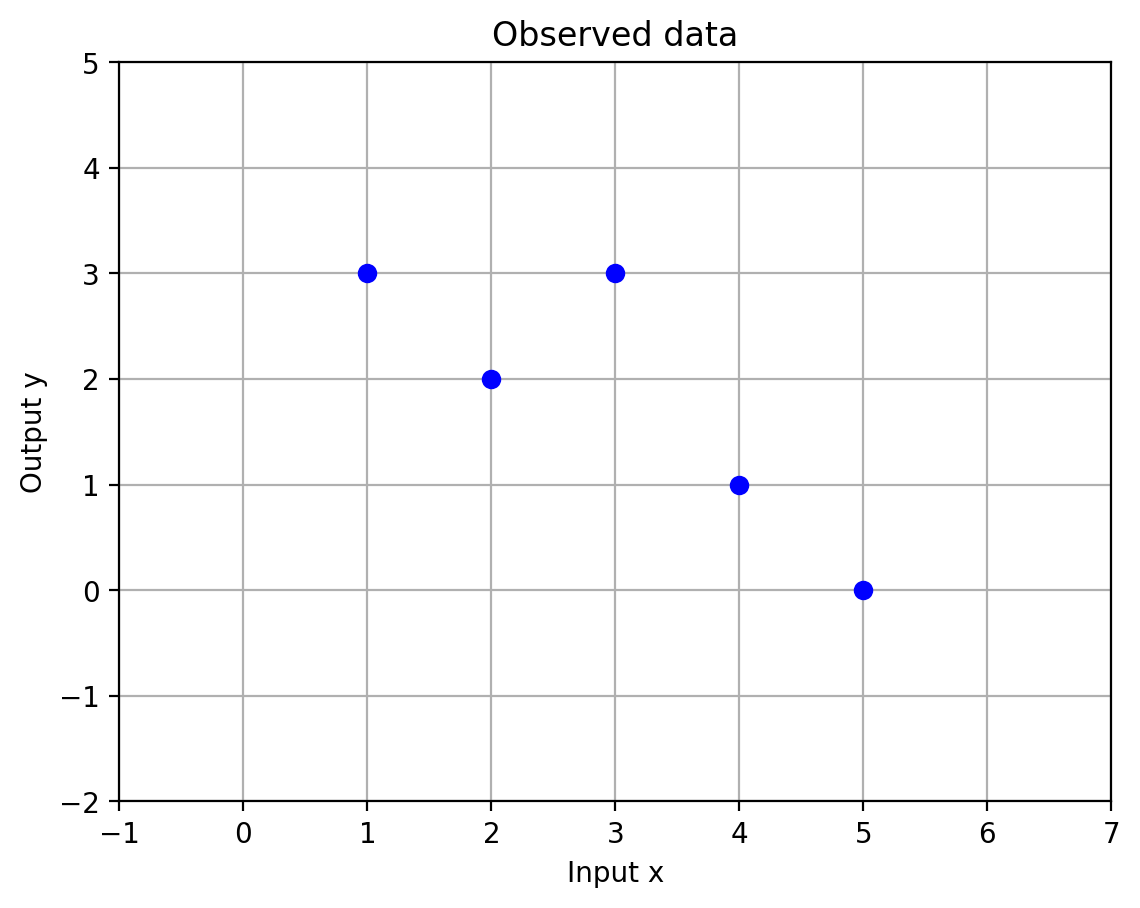

In [85]:
x_data_list = [1, 2, 3, 4, 5]
y_data_list = [3, 2, 3, 1, 0]

def plot_basic_data(parameters_list=None, title="Observed data"):
  xlim = [-1, 7]
  fig, ax = plt.subplots()
  
  if parameters_list is not None:
    x_pred = np.linspace(xlim[0], xlim[1], 100)
    for parameters in parameters_list:
      y_pred = parameters[0] + parameters[1] * x_pred
      ax.plot(x_pred, y_pred, ':', color=[1, 0.7, 0.6])

    parameters = parameters_list[-1]
    y_pred = parameters[0] + parameters[1] * x_pred
    ax.plot(x_pred, y_pred, "-", color=[1, 0, 0], lw=2)

  ax.plot(x_data_list, y_data_list, "ob")
  ax.set(xlabel="Input x", ylabel="Output y",
         title=title,
         xlim=xlim, ylim=[-2, 5])
  ax.grid()

plot_basic_data()

In [86]:
parameters_list = [[0.7, 0.88], [4.5, -0.85], [4.4, -0.85], [4.35, -0.85]]

Plotting line -0.85 * x + 4.33


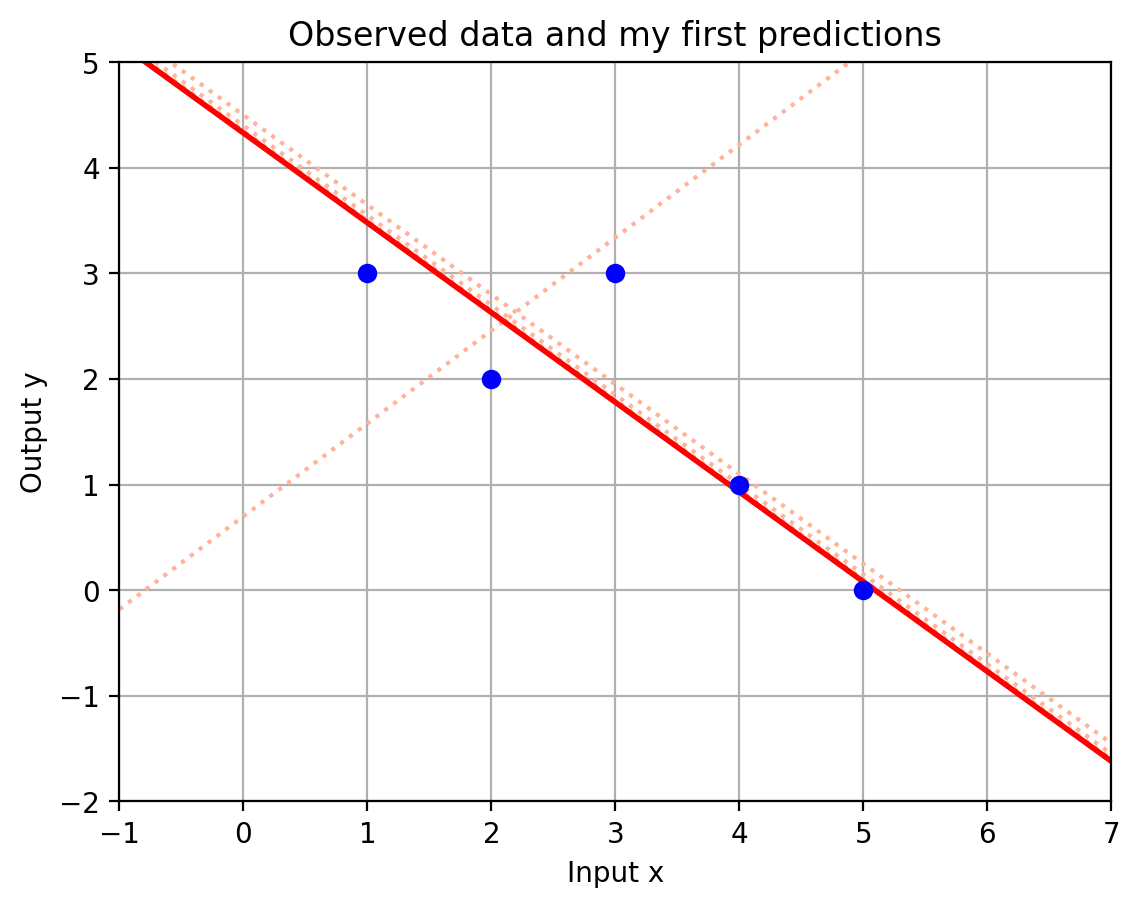

In [87]:
b = 4.33 # Bias
w = -0.85 # Weight
print("Plotting line", w, "* x +", b)
parameters = [b, w]
parameters_list.append(parameters)
plot_basic_data(parameters_list, title="Observed data and my first predictions")

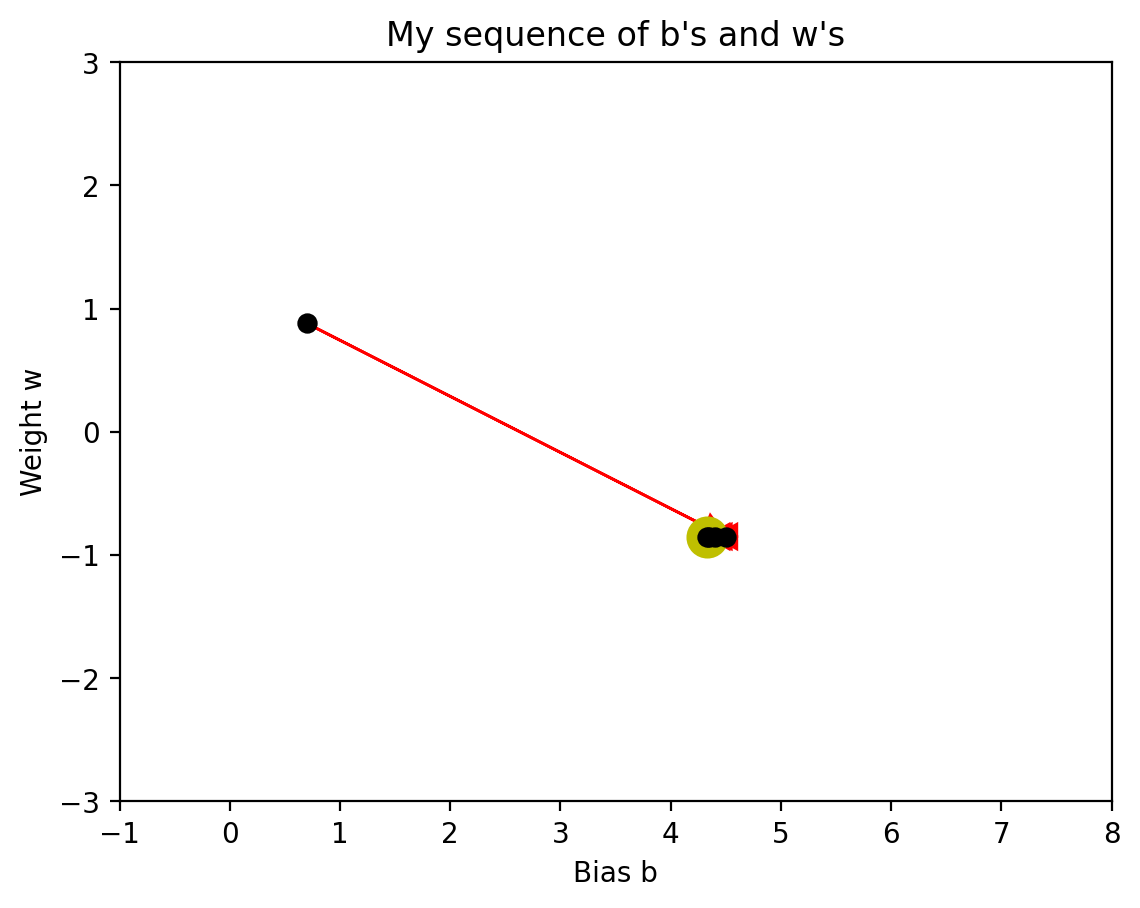

In [88]:
fig, ax = plt.subplots()
opt = {"head_width": 0.2, "head_length": 0.2,
       "length_includes_head": True, "color": "r"}
if parameters_list is not None:
  b_old = parameters_list[0][0]
  w_old = parameters_list[0][1]
  for i in range(1, len(parameters_list)):
    b_next = parameters_list[i][0]
    w_next = parameters_list[i][1]
    ax.arrow(b_old, w_old, b_next - b_old, w_next - w_old, **opt)
    b_old, w_old = b_next, w_next

  ax.scatter(b_old, w_old, s=200, marker="o", color="y")
  bs = [parameters[0] for parameters in parameters_list]
  ws =  [parameters[1] for parameters in parameters_list]
  ax.scatter(bs, ws, s=40, marker='o', color='k')

ax.set(xlabel="Bias b", ylabel="Weight w",
       title="My sequence of b\'s and w\'s",
       xlim=[-1, 8], ylim=[-3, 3])
plt.show()

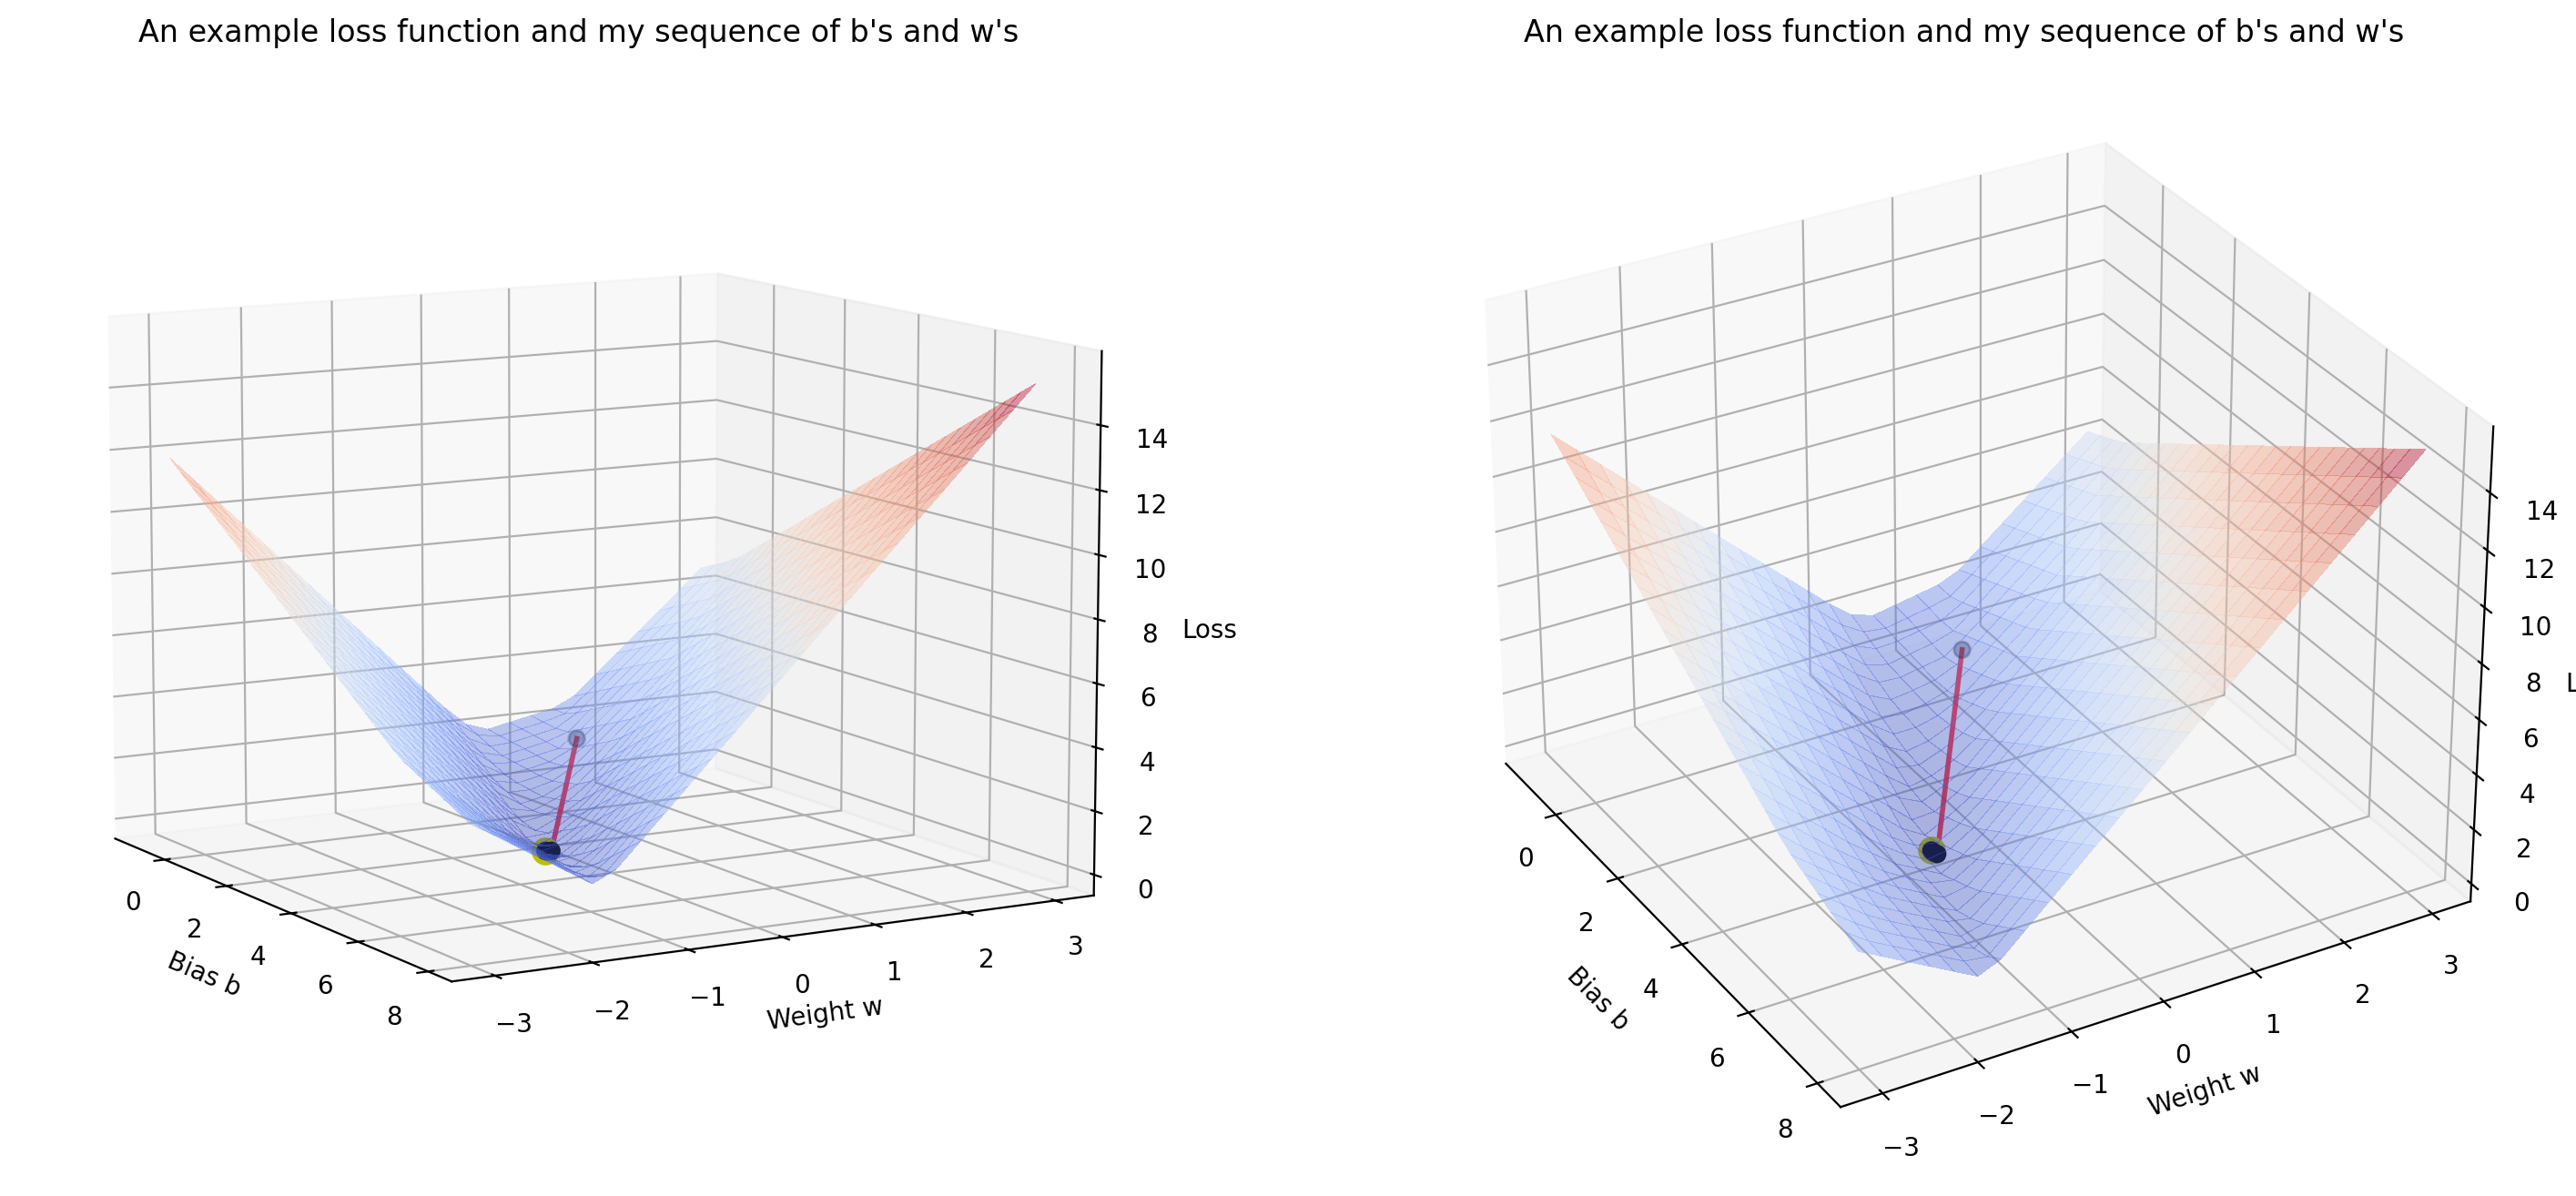

In [89]:
def l1_loss(b, w):
  loss = 0 * b
  for x, y in zip(x_data_list, y_data_list):
    f = w * x + b
    loss += np.abs(f - y)
  return loss / len(x_data_list)

bs, ws = np.linspace(-1, 8, num=25), np.linspace(-3, 3, num=25)
b_grid, w_grid = np.meshgrid(bs, ws)
loss_grid = l1_loss(b_grid, w_grid)

def plot_loss(parameters_list, title, show_stops=False):
  fig, ax = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={"projection": "3d"})
  ax[0].view_init(10, -30)
  ax[1].view_init(30, -30)

  if parameters_list is not None:
    b_old = parameters_list[0][0]
    w_old = parameters_list[0][1]
    loss_old = l1_loss(b_old, w_old)
    ls = [loss_old]

    for i in range(1, len(parameters_list)):
      b_next = parameters_list[i][0]
      w_next = parameters_list[i][1]
      loss_next = l1_loss(b_next, w_next)
      ls.append(loss_next)

      ax[0].plot([b_old, b_next], [w_old, w_next], [loss_old, loss_next], color="red", alpha=0.8, lw=2)
      ax[1].plot([b_old, b_next], [w_old, w_next], [loss_old, loss_next], color="red", alpha=0.8, lw=2)
      b_old, w_old, loss_old = b_next, w_next, loss_next

    if show_stops:
      ax[0].scatter(b_old, w_old, loss_old, s=100, marker="o", color="y")
      ax[1].scatter(b_old, w_old, loss_old, s=100, marker="o", color="y")
      bs = [parameters[0] for parameters in parameters_list]
      ws = [parameters[1] for parameters in parameters_list]
      ax[0].scatter(bs, ws, ls, s=40, marker="o", color="k")
      ax[1].scatter(bs, ws, ls, s=40, marker="o", color="k")
    else:
      ax[0].scatter(b_old, w_old, loss_old, s=40, marker='o', color='k')
      ax[1].scatter(b_old, w_old, loss_old, s=40, marker='o', color='k')

  ax[0].plot_surface(b_grid, w_grid, loss_grid, cmap=cm.coolwarm, linewidth=0, alpha=0.4, antialiased=False)
  ax[1].plot_surface(b_grid, w_grid, loss_grid, cmap=cm.coolwarm, linewidth=0, alpha=0.4, antialiased=False)
  ax[0].set(xlabel="Bias b", ylabel="Weight w", zlabel="Loss", title=title)
  ax[1].set(xlabel="Bias b", ylabel="Weight w", zlabel="Loss", title=title)
  plt.show()

plot_loss(parameters_list, "An example loss function and my sequence of b\'s and w\'s", show_stops=True)

In [90]:
def manual_grad(b, w):
  grad_b = 0
  grad_w = 0
  for x, y in zip(x_data_list, y_data_list):
    f = w * x + b
    grad_b += np.sign(f - y)
    grad_w += np.sign(f - y) * x
  grad_b /= len(x_data_list)
  grad_w /= len(x_data_list)
  return grad_b, grad_w

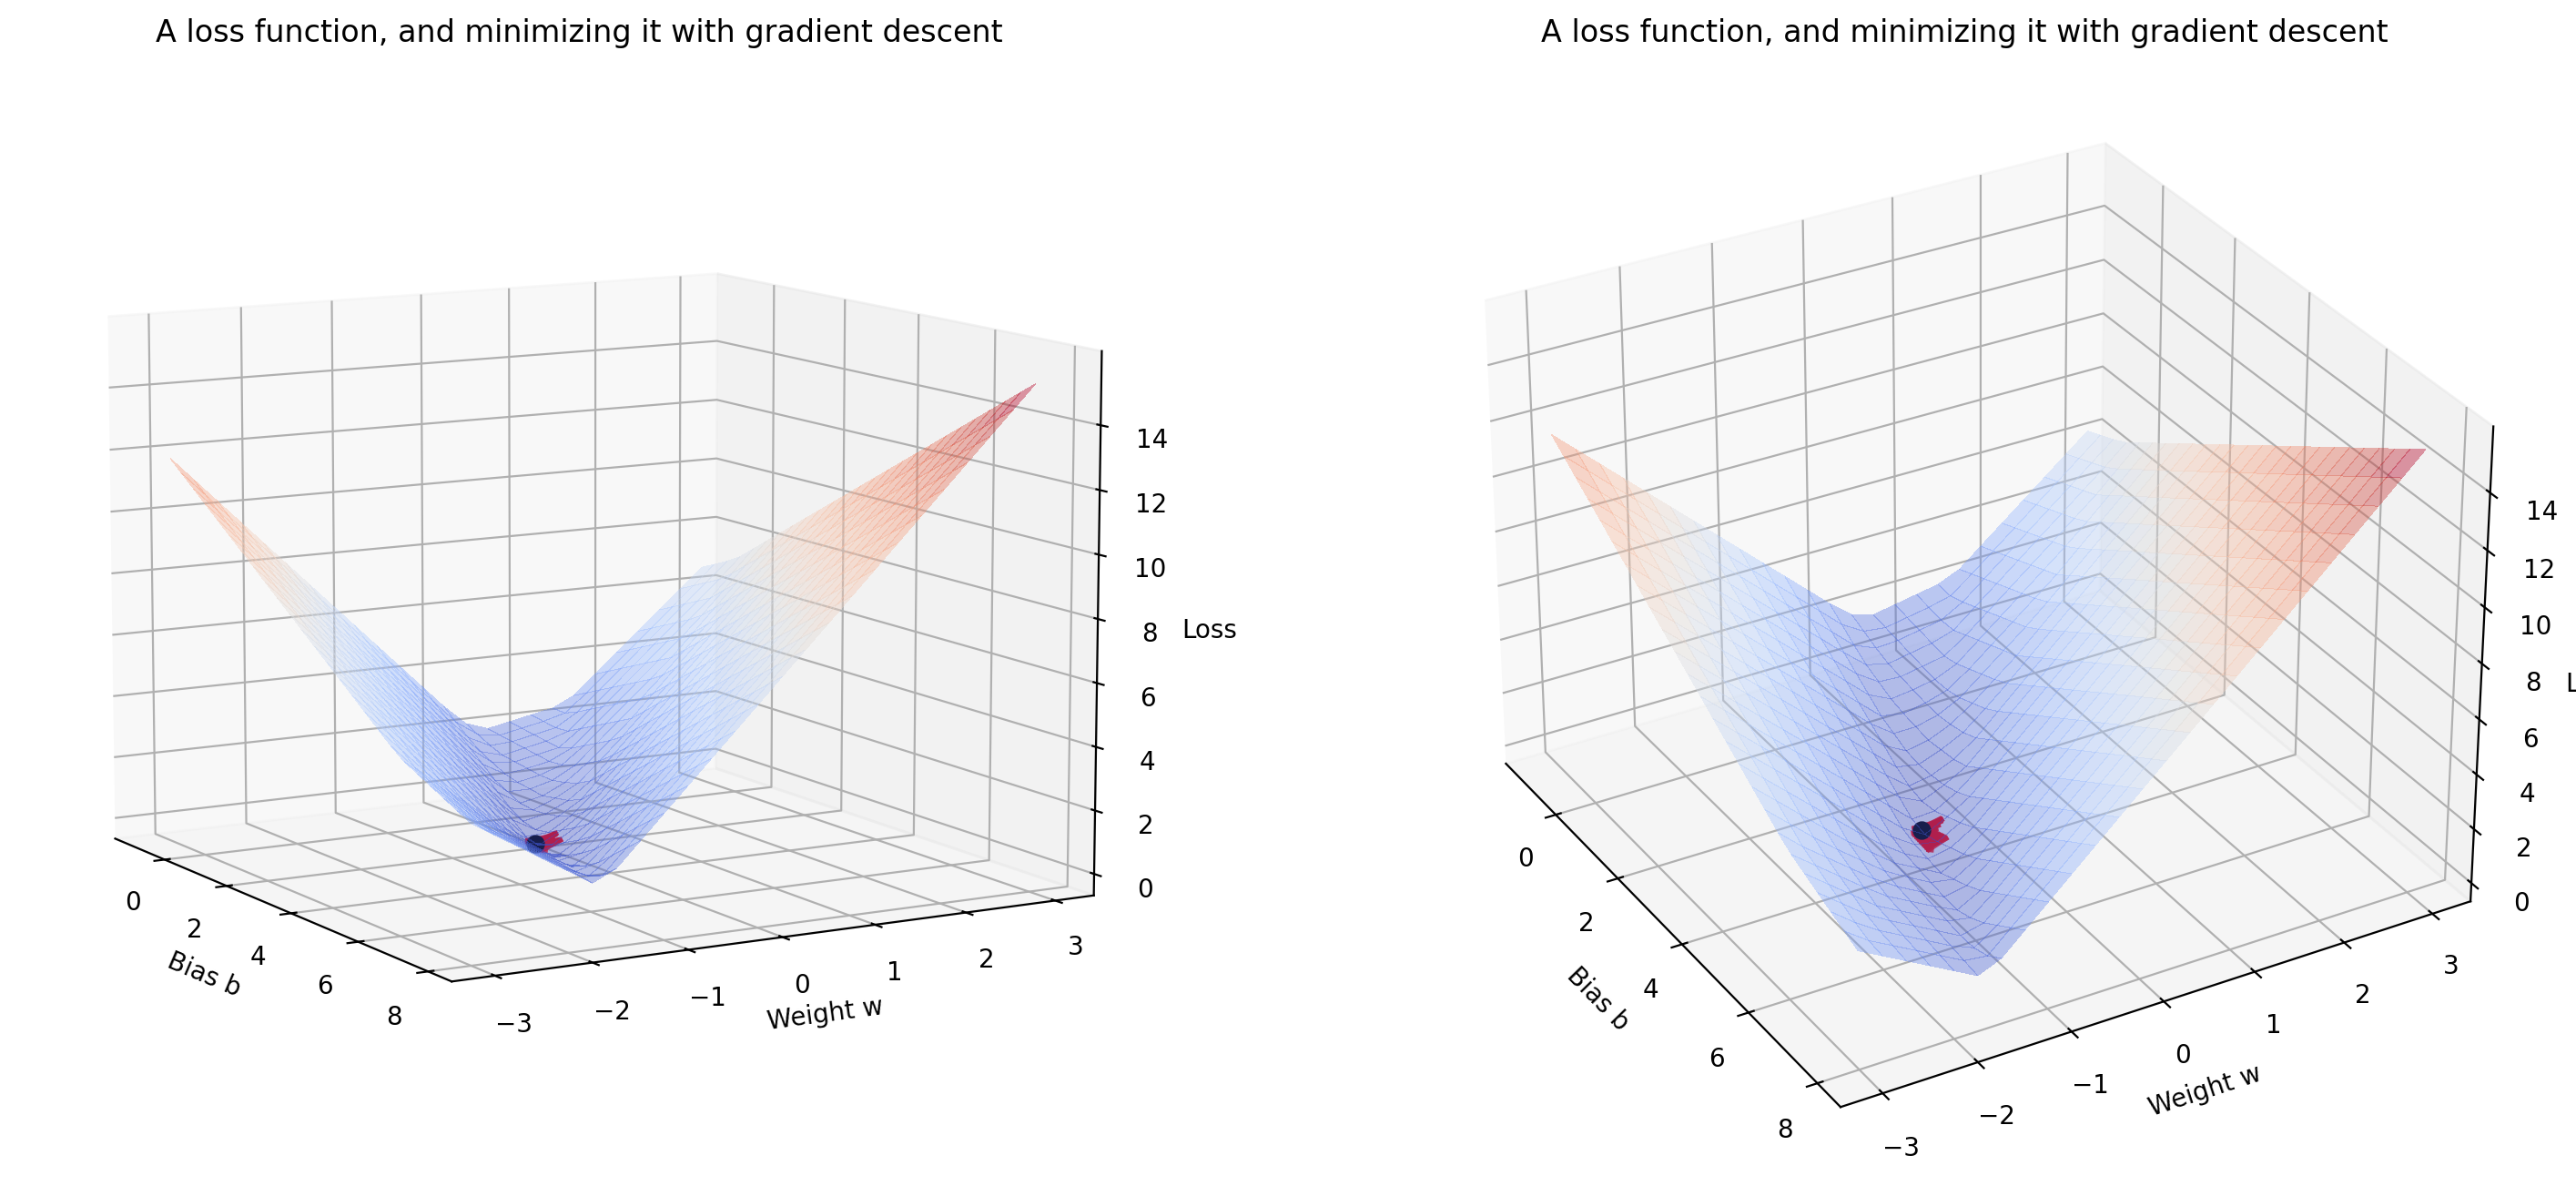

In [91]:
b = 4.33
w = -0.85
learning_rate = 0.1

parameters_step_list = []

for _ in range(200):
  parameters_step_list.append([b, w]) 
  grad_b, grad_w = manual_grad(b, w)
  b = b - learning_rate * grad_b
  w = w - learning_rate * grad_w

plot_loss(parameters_step_list, "A loss function, and minimizing it with gradient descent")

In [92]:
x = np.array(x_data_list)
y = np.array(y_data_list)

def loss_funtion(b, w):
    f = w * x + b
    errors = jnp.abs(f - y)
    return jnp.mean(errors)

auto_grad = jax.grad(loss_funtion, argnums=(0, 1))

b, w = 4.5, -0.85

grad_b, grad_w = auto_grad(b, w)
print("Auto grad:\n", "Grad b:" , grad_b, "\n", "Grad w:" , grad_w)

grad_b, grad_w = manual_grad(b, w)
print("\nManual grad:\n", "Grad b:" , grad_b, "\n", "Grad w:" , grad_w)

Auto grad:
 Grad b: 0.6 
 Grad w: 1.8

Manual grad:
 Grad b: 0.6 
 Grad w: 1.8


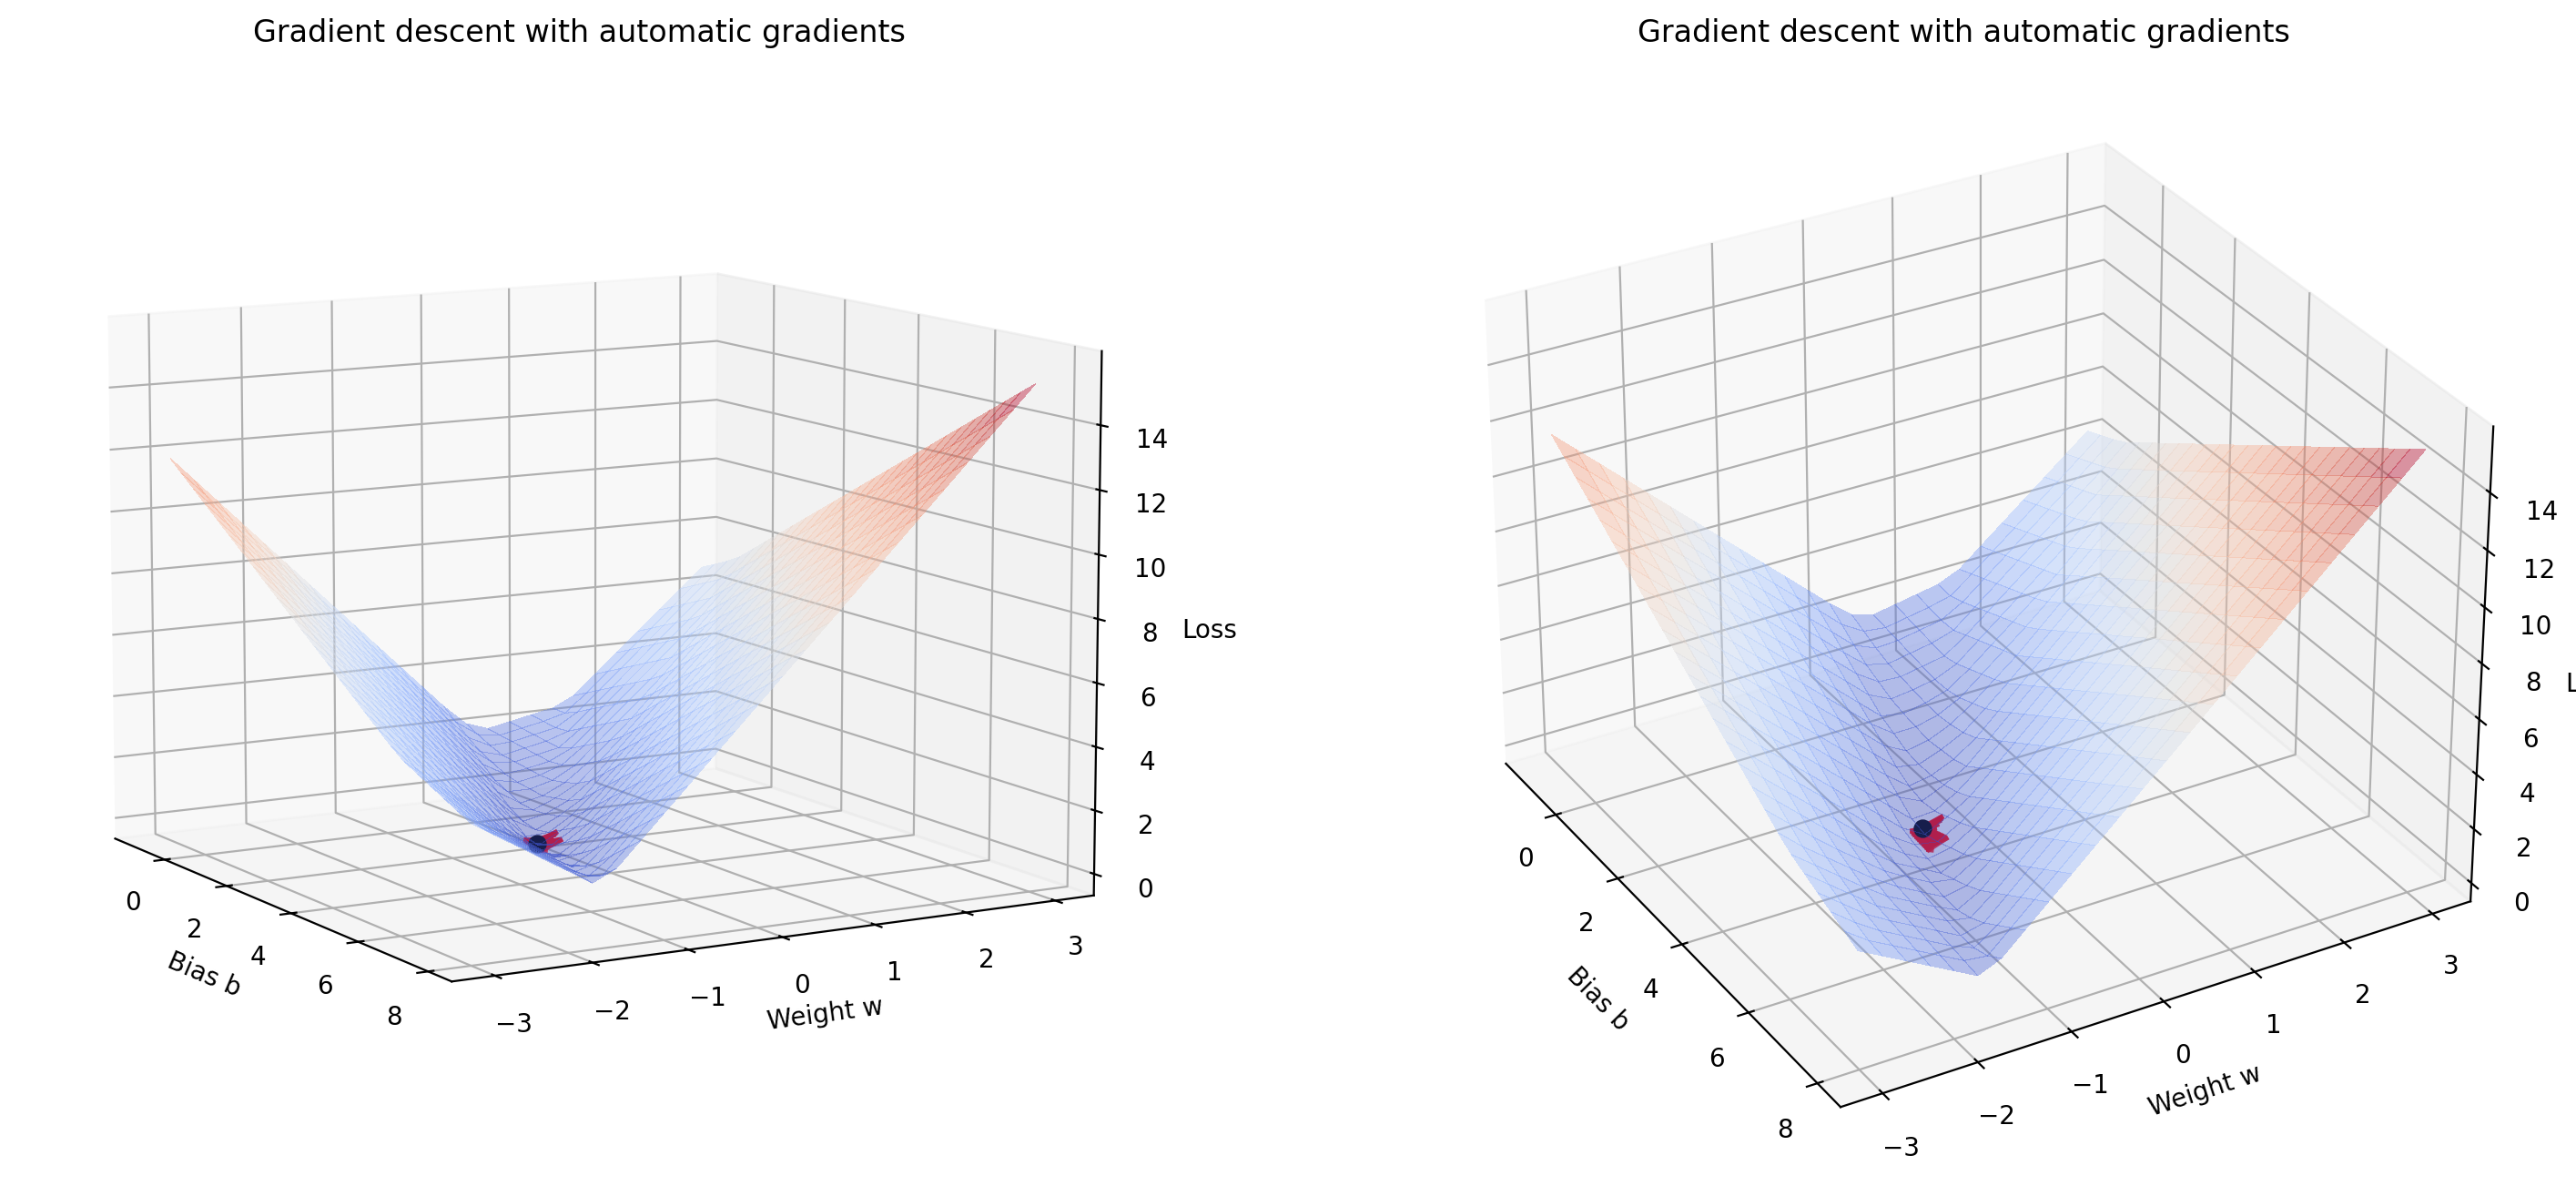

In [93]:
b, w = 4.33, -0.85
learning_rate = 0.1

parameters_step_list = []

for _ in range(200):
    parameters_step_list.append([b, w])
    grad_b, grad_w = auto_grad(b, w)
    b = b -learning_rate * grad_b
    w = w -learning_rate * grad_w

plot_loss(parameters_step_list, "Gradient descent with automatic gradients")

In [94]:
def generate_wave_like_dataset(min_x=-1, max_x=1, n=100):
    xs = np.linspace(min_x, max_x, n)
    ys = np.sin(5 * xs) + np.random.normal(size=len(xs), scale=0.2)
    return xs, ys

def regression_analytical_solution(X, y):
    return ((np.linalg.inv(X.T.dot(X))).dot(X.T)).dot(y)

def gradient_descent(X, y, learning_rate=1e-2, num_steps=1000):
    report_every = num_steps // 10

    def loss(current_w, X, y):
        y_hat = jnp.dot(X, current_w)
        loss = jnp.mean((y_hat - y) ** 2)
        return loss, y_hat

    loss_and_grad = jax.value_and_grad(loss, has_aux=True)
    # Initialize the parameters
    w = np.random.normal(size=(X.shape[1]))

    # Run a a few steps of gradient descent
    for i in range(num_steps):
        (loss, y_hat), grad = loss_and_grad(w, X, ys)

        if i % report_every == 0:
            print(f"Step {i}: w: {w}, Loss: {loss}, Grad: {grad}")

        w = w - learning_rate * grad

    return w

def plot_data(y_hat, xs, ys, title):
    plt.figure()
    plt.scatter(xs, ys, label="Data")
    plt.plot(xs, y_hat, 'r', label=title)

    plt.title(title)
    plt.xlabel("Input x")
    plt.ylabel("Output y")
    plt.legend();

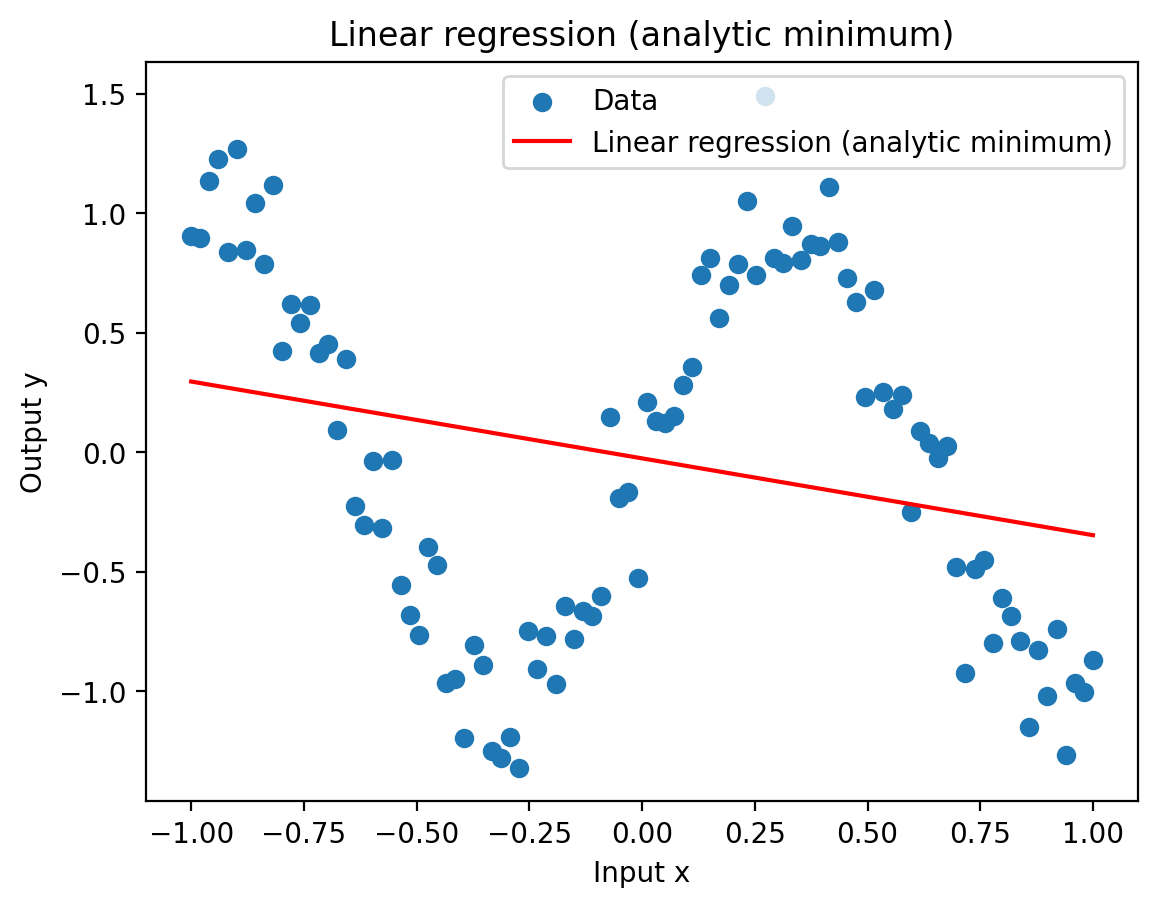

In [95]:
xs, ys = generate_wave_like_dataset()
X = np.vstack([xs, np.ones(len(xs))]).T
w = regression_analytical_solution(X, ys)
y_hat = X.dot(w)

plot_data(y_hat, xs, ys, "Linear regression (analytic minimum)")

In [96]:
def create_data_matrix(xs):
    return np.vstack([np.power(xs, 4), np.power(xs, 3), np.power(xs, 2), xs, np.ones(len(xs))]).T

phi = create_data_matrix(xs)

Step 0: w: [0.424347   1.19326235 0.66280519 0.71036762 0.44247767], Loss: 2.5443508625030518, Grad: [0.48410293 0.9775619  0.70788926 1.1985884  1.5639327 ]
Step 500: w: [ 0.0430353  -0.34034306  0.177521   -0.21219449 -0.10139047], Loss: 0.47995948791503906, Grad: [ 0.01881929  0.1284448   0.02033978 -0.06727096 -0.01259048]
Step 1000: w: [-0.00627715 -0.90479     0.12190253  0.13559768 -0.06747277], Loss: 0.39024168252944946, Grad: [ 0.0042097   0.10204525  0.00530159 -0.06568739 -0.0031104 ]
Step 1500: w: [-0.01644256 -1.3729943   0.10665411  0.43745467 -0.05901397], Loss: 0.3279356360435486, Grad: [ 0.00066142  0.08571085  0.00162451 -0.05528311 -0.00079534]
Step 2000: w: [-0.01712758 -1.7664311   0.10130519  0.6912233  -0.05676958], Loss: 0.2839871048927307, Grad: [-0.0001912   0.07203288  0.00071667 -0.04646192 -0.00022973]
Step 2500: w: [-0.01556253 -2.0970843   0.09842556  0.90449744 -0.05604649], Loss: 0.2529487907886505, Grad: [-3.8702786e-04  6.0538113e-02  4.8437575e-04 -3

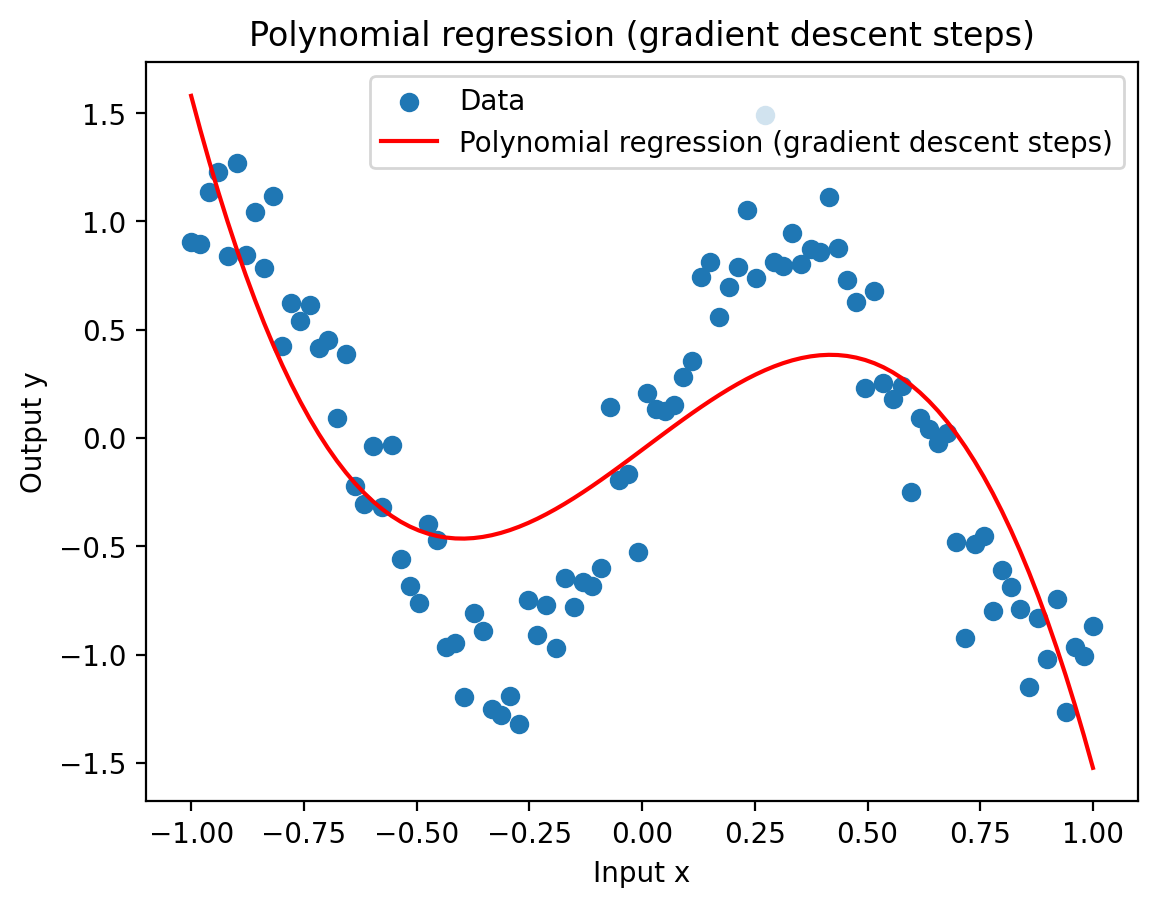

In [97]:
w = gradient_descent(phi, ys, num_steps=5000)
print("w:", w)
y_hat = phi.dot(w)

plot_data(y_hat, xs, ys, 'Polynomial regression (gradient descent steps)')

w: [ 0.04968893 -3.83848667  0.03859971  2.02771617 -0.04923747]


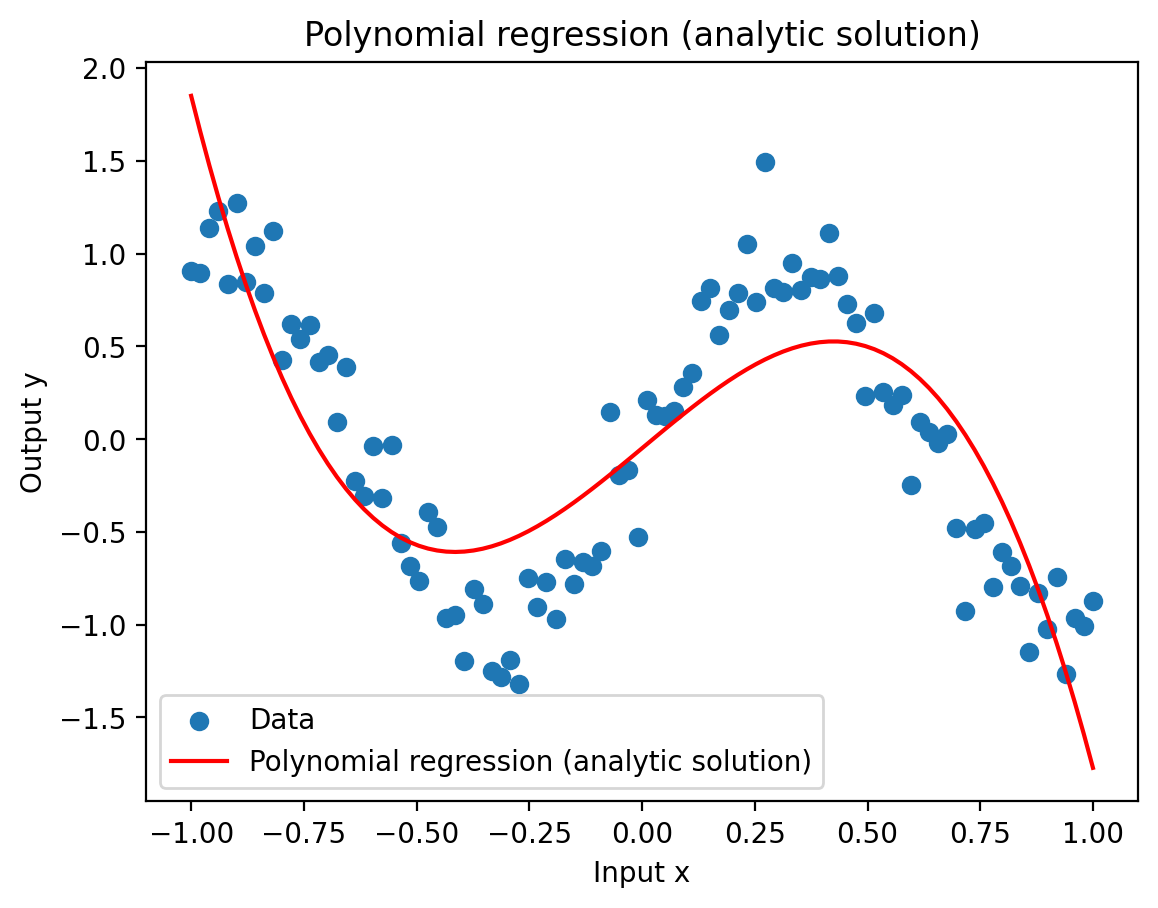

In [98]:
w = regression_analytical_solution(phi, ys)
print("w:", w)
y_hat = phi.dot(w)

plot_data(y_hat, xs, ys, "Polynomial regression (analytic solution)")

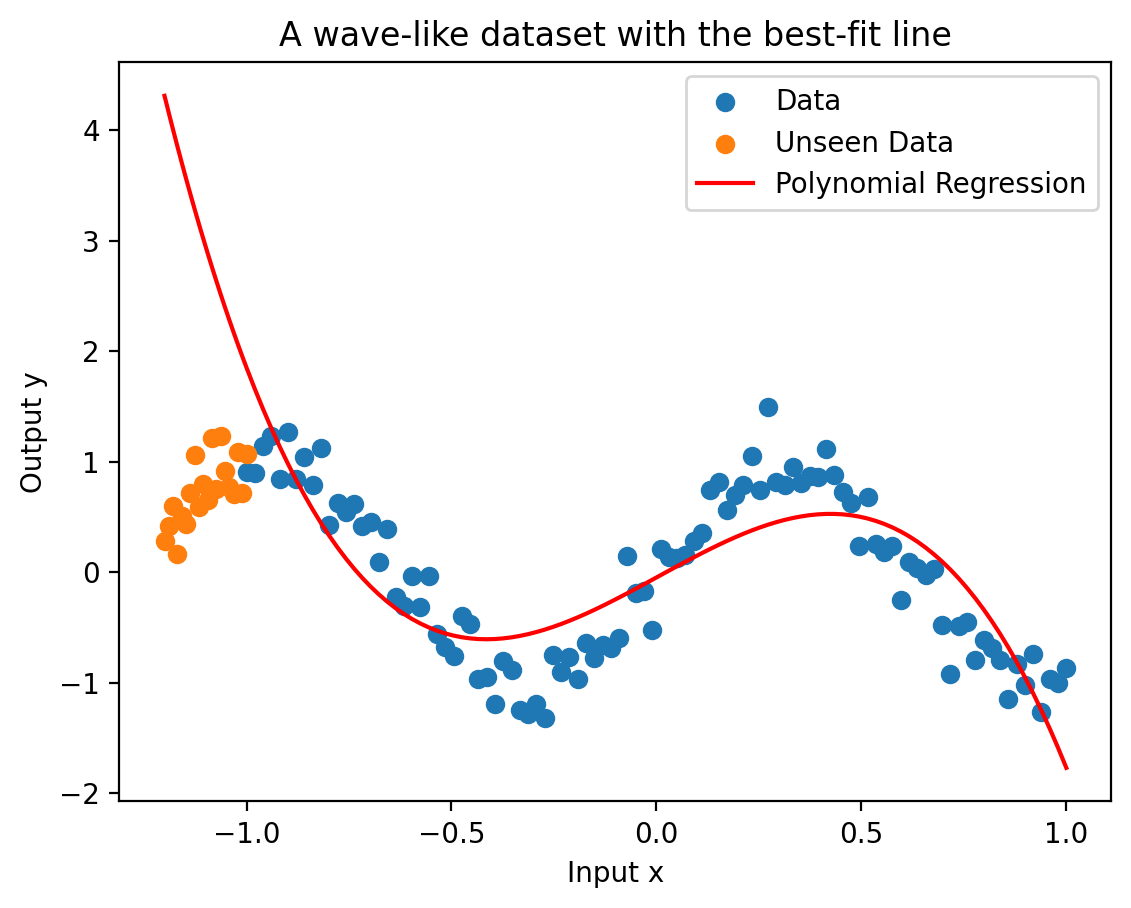

In [99]:
phi = create_data_matrix(xs)
w = regression_analytical_solution(phi, ys)

more_xs, more_ys = generate_wave_like_dataset(min_x=-1.2, max_x=-1, n=20)
all_xs = np.concatenate([more_xs, xs])
all_ys = np.concatenate([more_ys, ys])

phi = create_data_matrix(all_xs)

y_hat = phi.dot(w)

plt.scatter(xs, ys, label="Data")
plt.scatter(more_xs, more_ys, label="Unseen Data")
plt.plot(all_xs, y_hat, 'r', label='Polynomial Regression')

plt.title("A wave-like dataset with the best-fit line")
plt.xlabel("Input x")
plt.ylabel("Output y")
plt.legend()
plt.show()

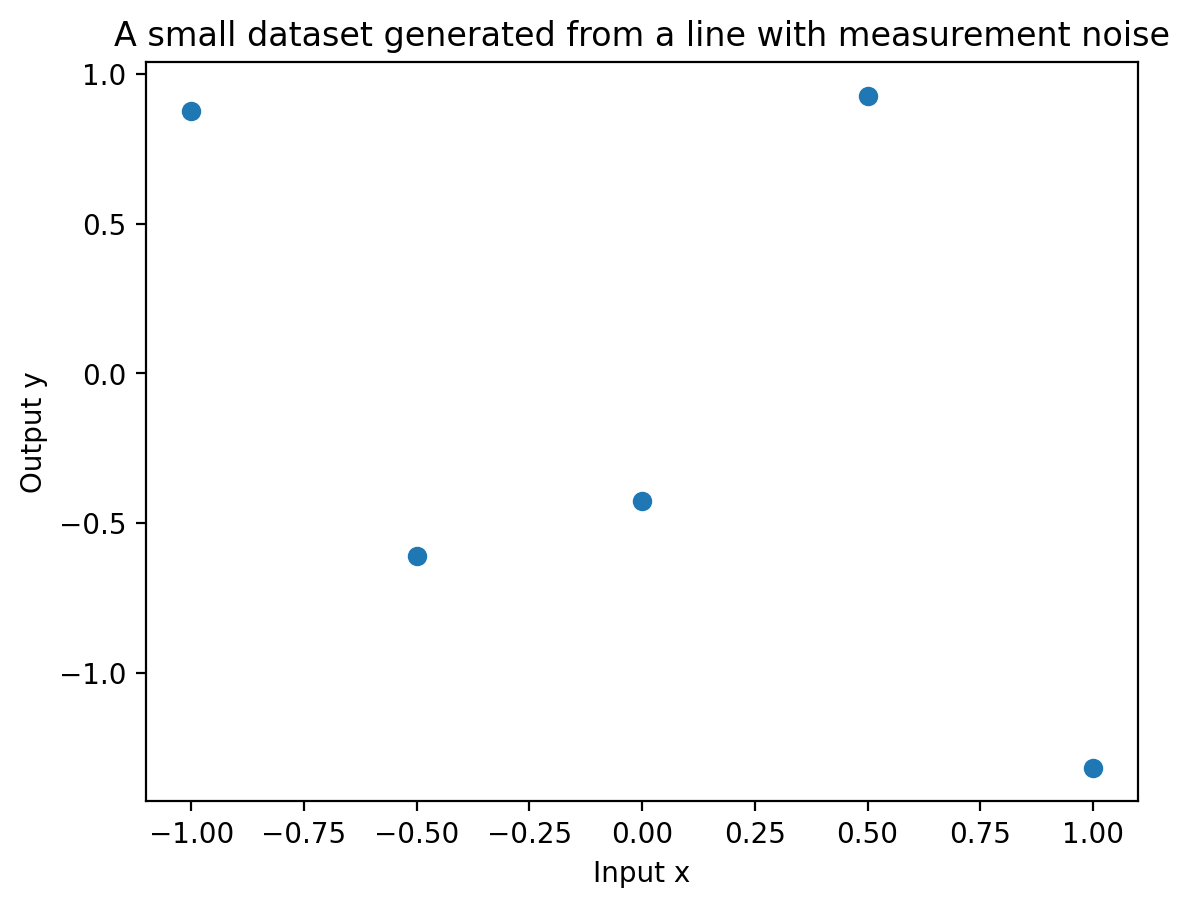

In [100]:
np.random.seed(2)

xs_small, ys_small = generate_wave_like_dataset(n=5)

plt.figure()
plt.scatter(xs_small, ys_small)
plt.title("A small dataset generated from a line with measurement noise")
plt.xlabel("Input x")
plt.ylabel("Output y")
plt.show()

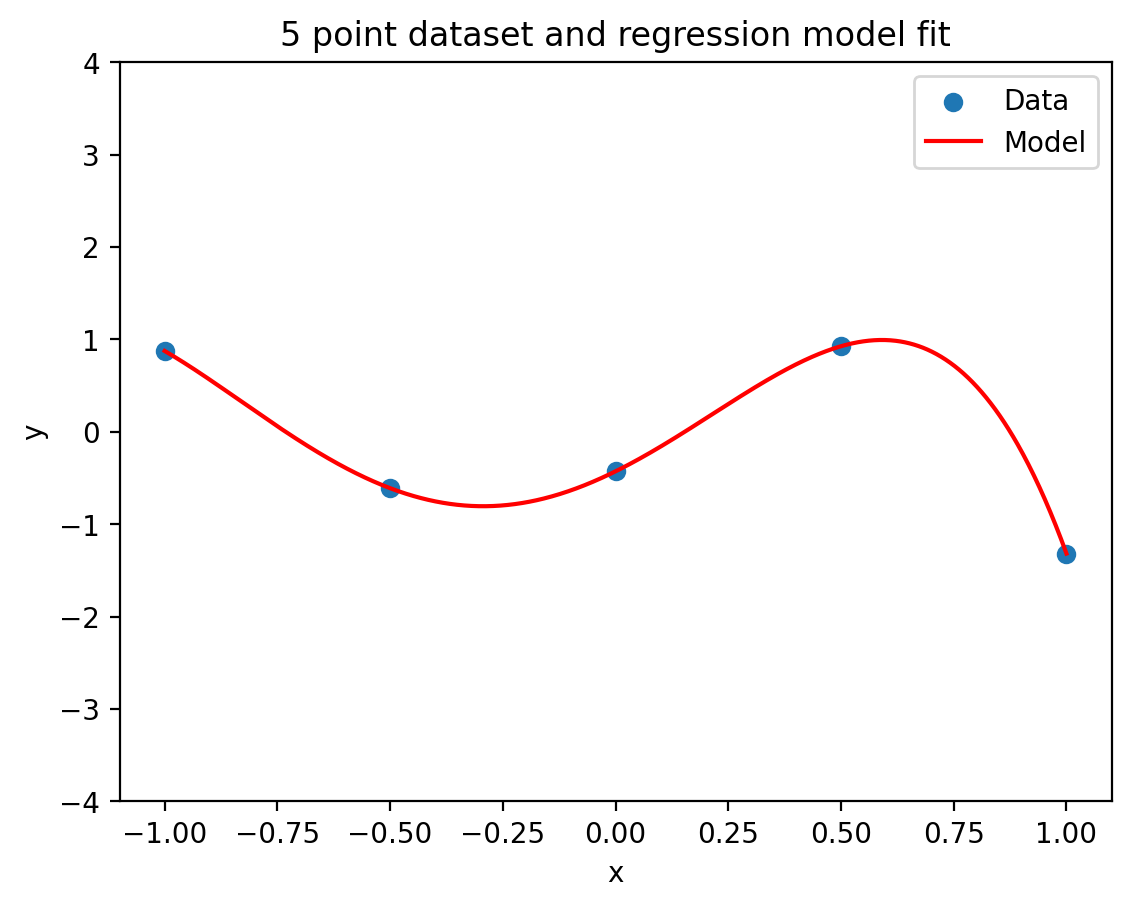

[-2.84845146 -3.51045849  3.05467133  2.41386644 -0.42723922]
Loss: 4.876762767979583e-30


In [101]:
phi_small = create_data_matrix(xs_small)
w_first = regression_analytical_solution(phi_small, ys_small)

xs_plot = np.linspace(-1, 1, 1000)
phi_plot = create_data_matrix(xs_plot)
y_hat = phi_plot.dot(w_first)

plt.figure()
plt.scatter(xs_small, ys_small, label="Data")
plt.plot(xs_plot, y_hat, c='r', label="Model")
plt.ylim(-4, 4)

plt.legend()
plt.title("5 point dataset and regression model fit")
plt.xlabel("x")
plt.ylabel("y");
plt.show()

print(w_first)
loss = np.mean(np.power(phi_small.dot(w_first) - ys_small, 2))
print("Loss:", loss)

Loss on training data: 4.876762767979583e-30
Loss on unseen data:   0.3434506774909566


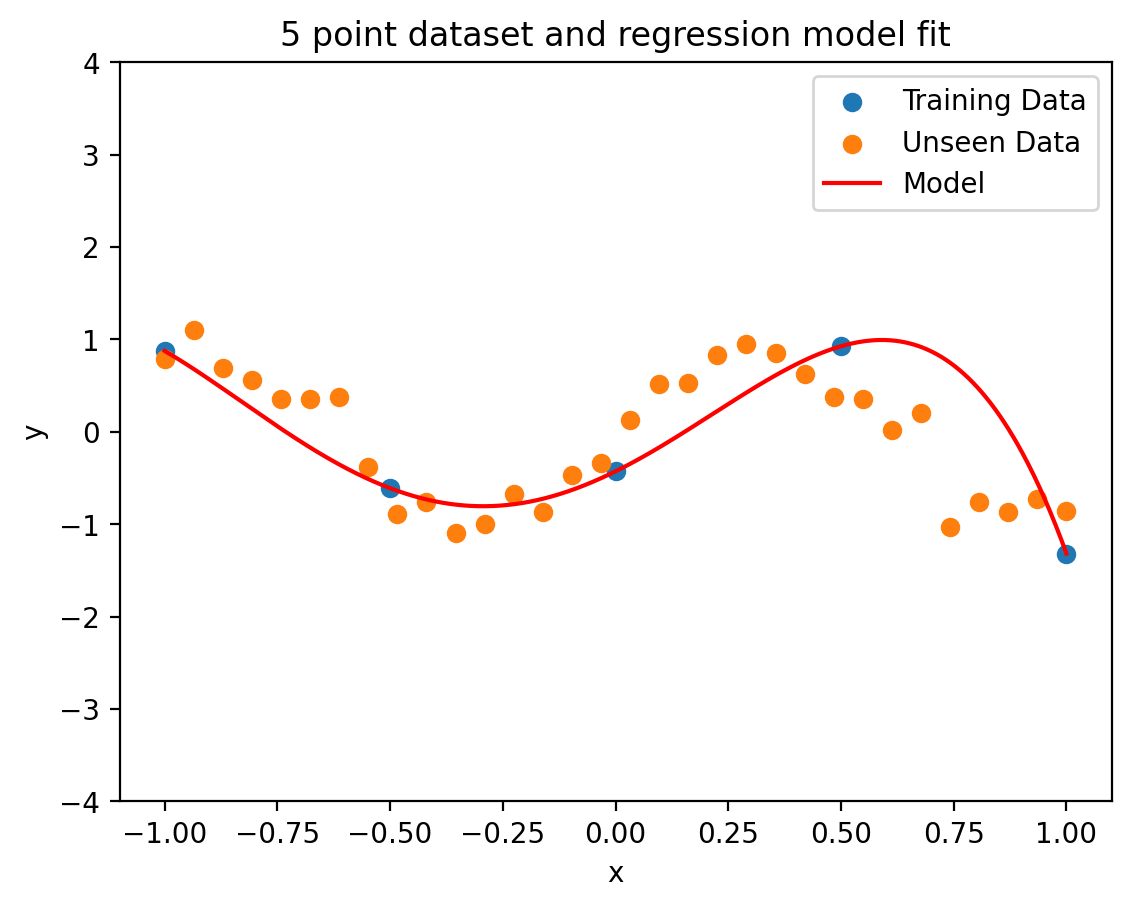

In [102]:
xs_more, ys_more = generate_wave_like_dataset(n=32)

plt.figure()
plt.scatter(xs_small, ys_small, label="Training Data")
plt.scatter(xs_more, ys_more, label="Unseen Data")
plt.plot(xs_plot, y_hat, c="r", label="Model")
plt.ylim(-4, 4)

plt.legend()
plt.title("5 point dataset and regression model fit")

plt.xlabel("x")
plt.ylabel("y");

phi_more = create_data_matrix(xs_more)
loss_training = np.mean(np.power(phi_small.dot(w_first) - ys_small, 2))
loss_validation = np.mean(np.power(phi_more.dot(w_first) - ys_more, 2))
print("Loss on training data:", loss_training)
print("Loss on unseen data:  ", loss_validation)

In [103]:
def gradient_descent_with_validation(phi_train, y_train, phi_val, y_val, learning_rate=1e-1, num_steps=1000):
    def loss(current_w, phi, y):
        y_hat = jnp.dot(phi, current_w)
        loss = jnp.mean((y_hat - y) ** 2)
        return loss, y_hat

    loss_and_grad = jax.value_and_grad(loss, has_aux=True)

    w =  0.2 * np.random.normal(size=(phi_train.shape[1]))

    train_losses = []
    val_losses = []

    for i in range(num_steps):
        (train_loss, y_hat), grad = loss_and_grad(w, phi_train, y_train)
        (val_loss, y_hat), _ = loss_and_grad(w, phi_val, y_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        w = w - learning_rate * grad

    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label="Train")
    plt.plot(range(len(val_losses)), val_losses, label="Validation")
    plt.title("Train and validation loss curves")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()

    return w

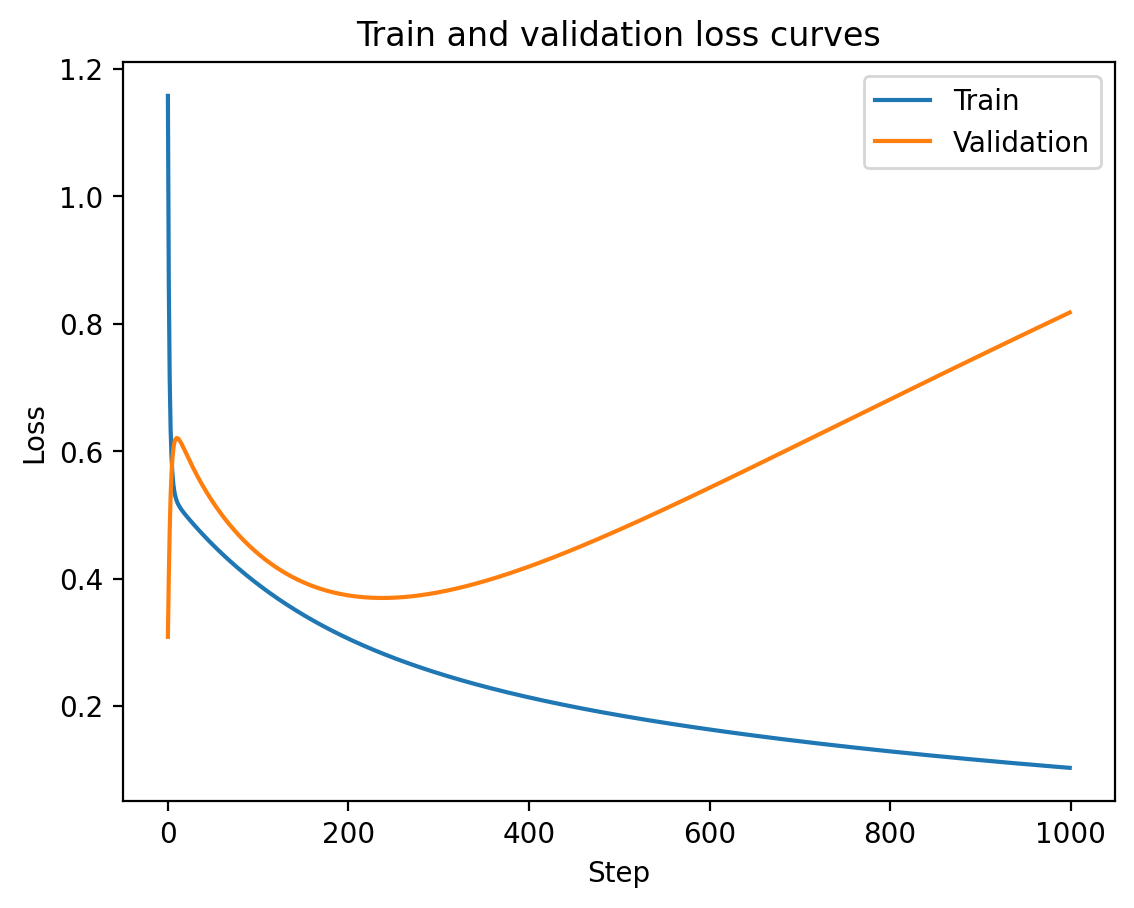

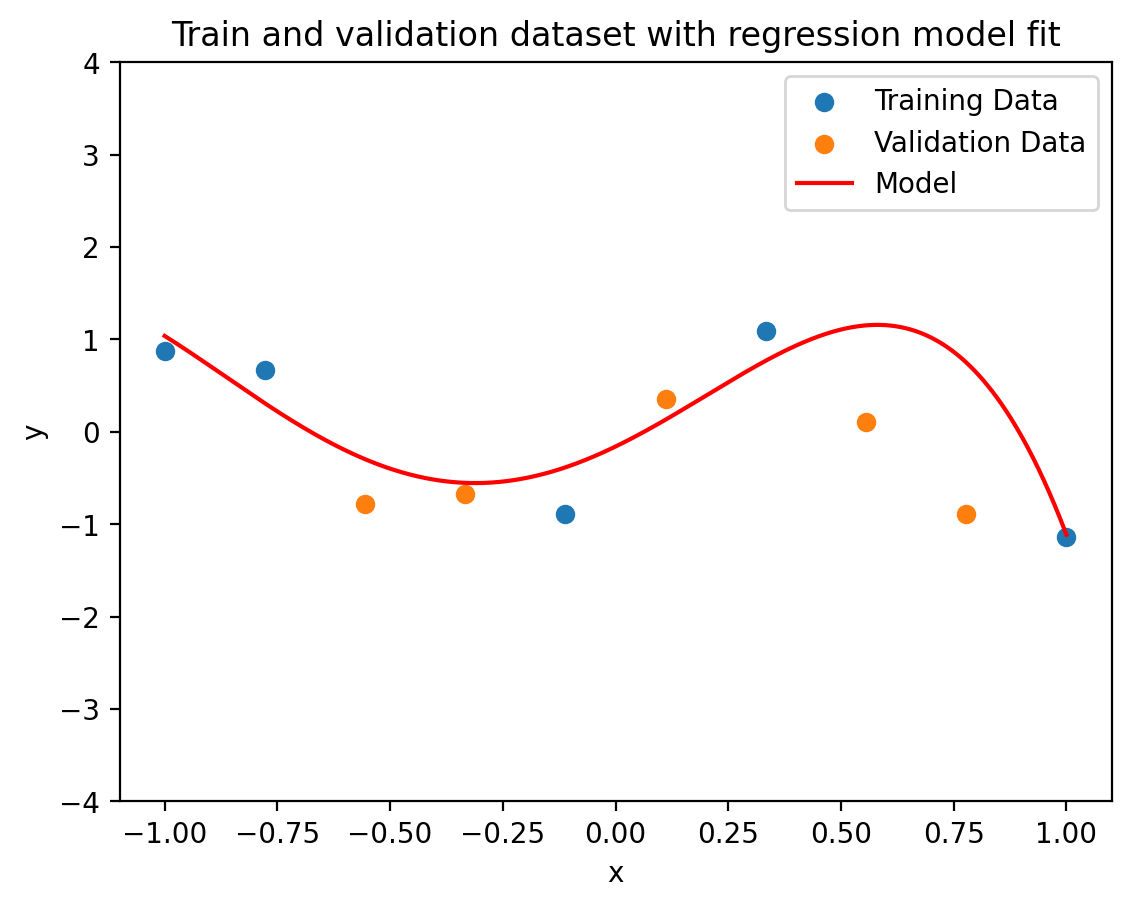

In [104]:
np.random.seed(2)

n=10
x_all, y_all = generate_wave_like_dataset(n=n)

training_set = np.random.permutation(n) < 0.5 * n
x_train = x_all[training_set]
y_train = y_all[training_set]
phi_train = create_data_matrix(x_train)

x_val = x_all[~training_set]
y_val = y_all[~training_set]
phi_val = create_data_matrix(x_val)

w_gd_val = gradient_descent_with_validation(phi_train, y_train, phi_val, y_val)

y_hat = phi_plot.dot(w_gd_val)

plt.figure()
plt.scatter(x_train, y_train, label="Training Data")
plt.scatter(x_val, y_val, label="Validation Data")
plt.plot(xs_plot, y_hat, c="r", label="Model")
plt.ylim(-4, 4)

plt.legend()
plt.title("Train and validation dataset with regression model fit")

plt.xlabel("x")
plt.ylabel("y");

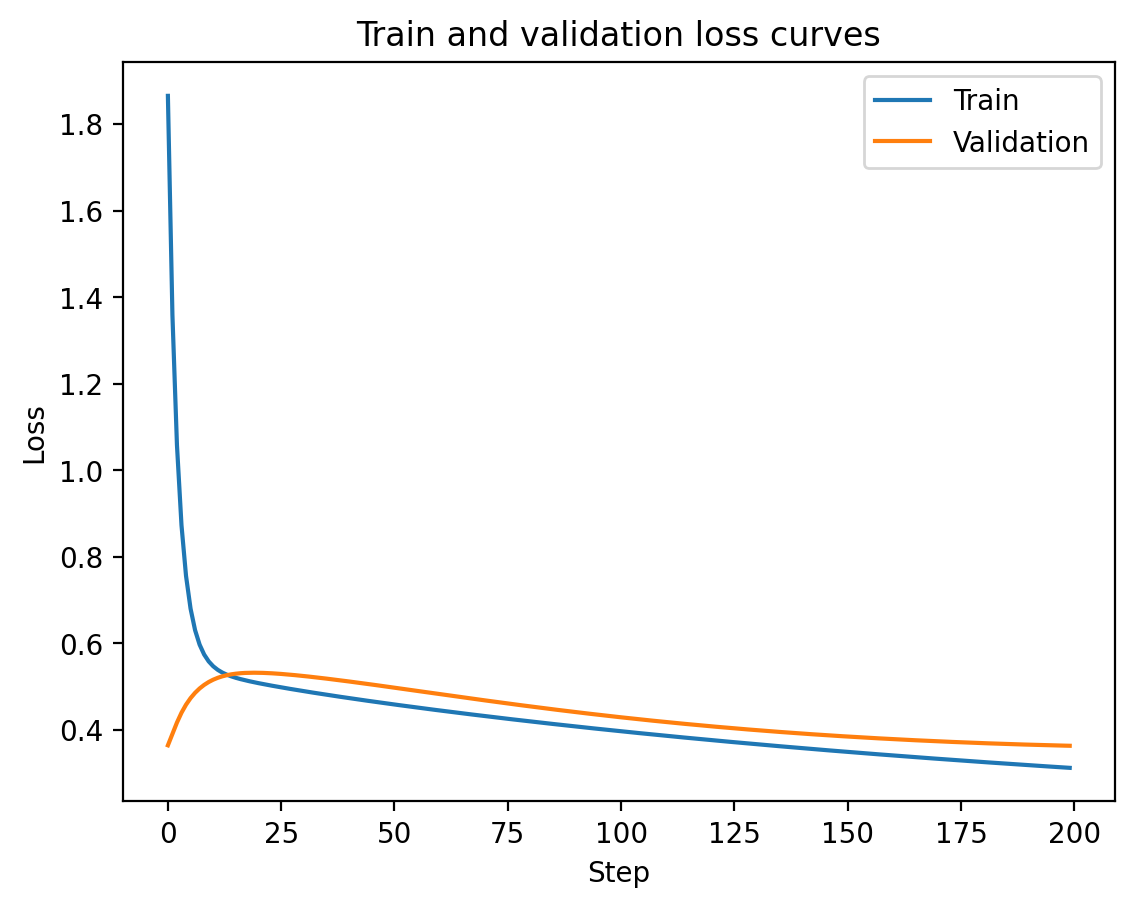

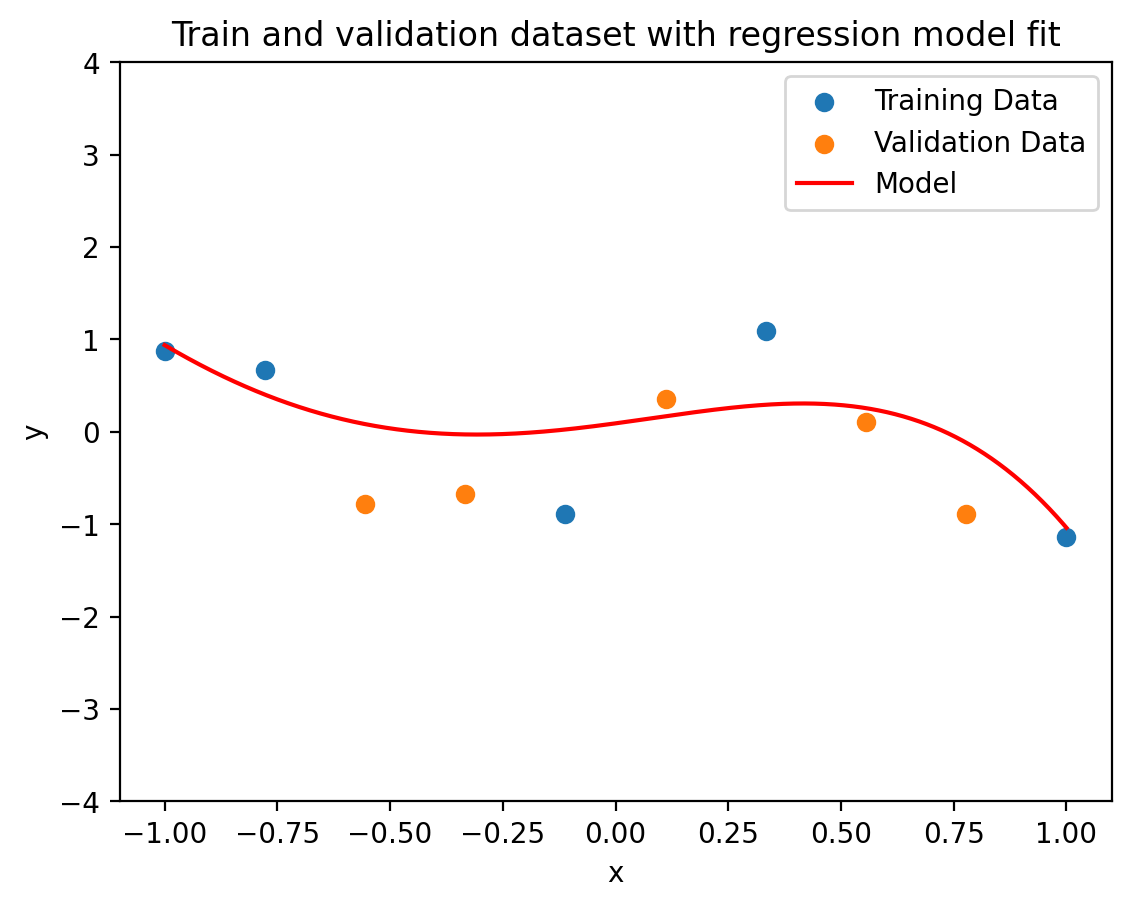

In [105]:
w_early_stopping = gradient_descent_with_validation(phi_train, y_train, phi_val, y_val, num_steps=200)

y_hat = phi_plot.dot(w_early_stopping)

plt.figure()
plt.scatter(x_train, y_train, label="Training Data")
plt.scatter(x_val, y_val, label="Validation Data")
plt.plot(xs_plot, y_hat, c="r", label="Model")
plt.ylim(-4, 4)

plt.legend()
plt.title("Train and validation dataset with regression model fit")

plt.xlabel("x")
plt.ylabel("y");

In [106]:
print("First model parameters:", w_first)
print("First model parameter L2-norm:", np.linalg.norm(w_first, 2))
print()
print("Early stopping model parameters:", w_early_stopping)
print("Early stopping model parameter L2-norm:", np.linalg.norm(w_early_stopping, 2))

First model parameters: [-2.84845146 -3.51045849  3.05467133  2.41386644 -0.42723922]
First model parameter L2-norm: 5.981412538858834

Early stopping model parameters: [-0.57117933 -1.6541141   0.42961228  0.6657491   0.0919053 ]
Early stopping model parameter L2-norm: 1.9231678


In [107]:
def regularized_regression_analytical_solution(phi, y, regularization_coef):
    t = phi.shape[0]
    return (np.linalg.inv(phi.T.dot(phi) + regularization_coef * np.identity(t)).dot(phi.T)).dot(y)

regularization_coefs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
min_validation_error = np.Inf

training_errors = []
validation_errors = []

for regularization_coef in regularization_coefs:
    w_reg = regularized_regression_analytical_solution(phi_train, y_train, regularization_coef)
    training_error = jnp.mean((jnp.dot(phi_train, w_reg) - y_train) ** 2)
    training_errors.append(training_error)
    validation_error = jnp.mean((jnp.dot(phi_val, w_reg) - y_val) ** 2)
    validation_errors.append(validation_error)

    if validation_error < min_validation_error:
        min_validation_error = validation_error
        best_regularization_coef = regularization_coef
        best_w_reg = w_reg

In [108]:
print("Best value for hyperparameter alpha:", best_regularization_coef)
print("Weights for the regularized regression:", best_w_reg)
print("L2-norm for the weights for the regularized regression:", np.linalg.norm(best_w_reg, 2))

Best value for hyperparameter alpha: 0.1
Weights for the regularized regression: [-0.71353478 -1.71800367  0.60917528  0.74705382  0.06198772]
L2-norm for the weights for the regularized regression: 2.09611424036858


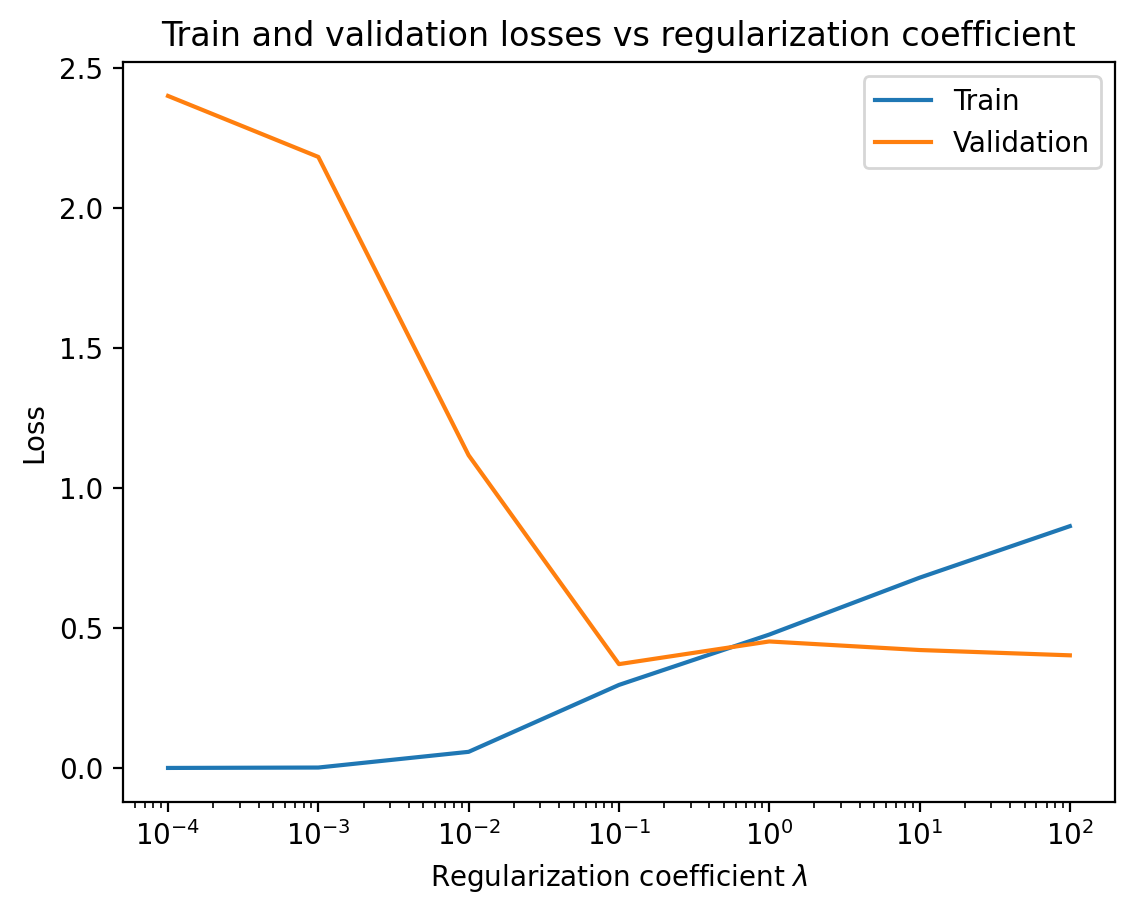

In [109]:
plt.figure()
plt.semilogx(np.array(regularization_coefs), np.array(training_errors), label="Train")
plt.semilogx(np.array(regularization_coefs), np.array(validation_errors), label="Validation")
plt.title("Train and validation losses vs regularization coefficient")
plt.xlabel("Regularization coefficient $\lambda$")
plt.ylabel("Loss")
plt.legend()
plt.show()

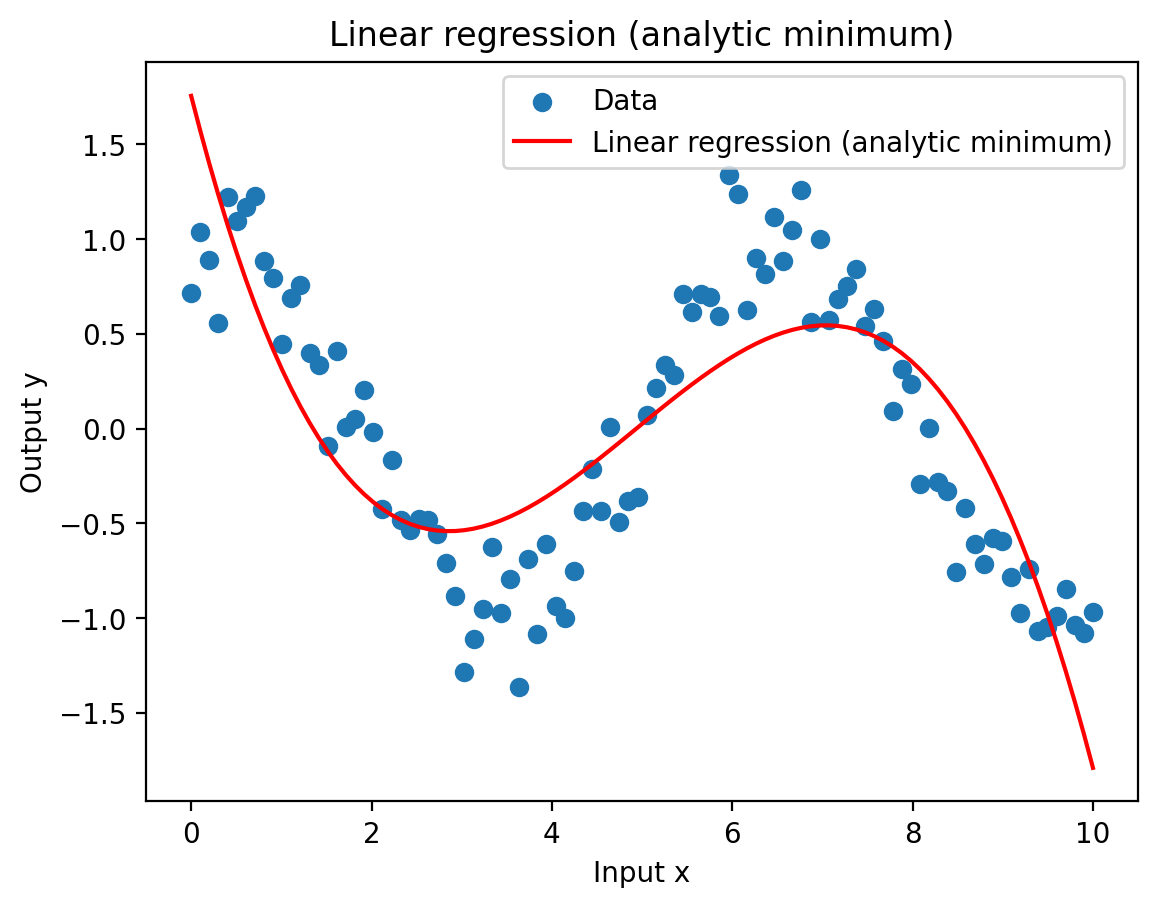

In [110]:
xs, ys = generate_wave_like_dataset(n=100)
xs = 5 * (xs + 1)
phi = create_data_matrix(xs)

w = regression_analytical_solution(phi, ys)
y_hat = phi.dot(w)

plot_data(y_hat, xs, ys, "Linear regression (analytic minimum)")

In [111]:
gradient_descent(phi, ys, num_steps=10)

Step 0: w: [ 1.96231586 -1.49139809 -0.02272573  0.17340019  0.89790379], Loss: 37102832.0, Grad: [4.1321880e+07 4.6188720e+06 5.2422344e+05 6.0689449e+04 7.2171060e+03]
Step 1: w: [-4.1321681e+05 -4.6190211e+04 -5.2422573e+03 -6.0672107e+02
 -7.1273155e+01], Loss: 2.0148879058093998e+18, Grad: [-9.6301031e+12 -1.0782328e+12 -1.2264769e+11 -1.4243102e+10
 -1.7016242e+09]
Step 2: w: [9.6300622e+10 1.0782282e+10 1.2264717e+09 1.4243040e+08 1.7016170e+07], Loss: 1.094387559545186e+29, Grad: [2.2443523e+18 2.5128864e+17 2.8583793e+16 3.3194441e+15 3.9657460e+14]
Step 3: w: [-2.2443425e+16 -2.5128756e+15 -2.8583668e+14 -3.3194299e+13
 -3.9657288e+12], Loss: inf, Grad: [-5.2305948e+23 -5.8564287e+22 -6.6616210e+21 -7.7361582e+20
 -9.2424033e+19]
Step 4: w: [5.2305724e+21 5.8564035e+20 6.6615922e+19 7.7361248e+18 9.2423635e+17], Loss: inf, Grad: [1.2190210e+29 1.3648755e+28 1.5525301e+27 1.8029573e+26 2.1539966e+25]
Step 5: w: [-1.21901575e+27 -1.36486961e+26 -1.55252341e+25 -1.80294946e+24
 

Array([nan, nan, nan, nan, nan], dtype=float32)

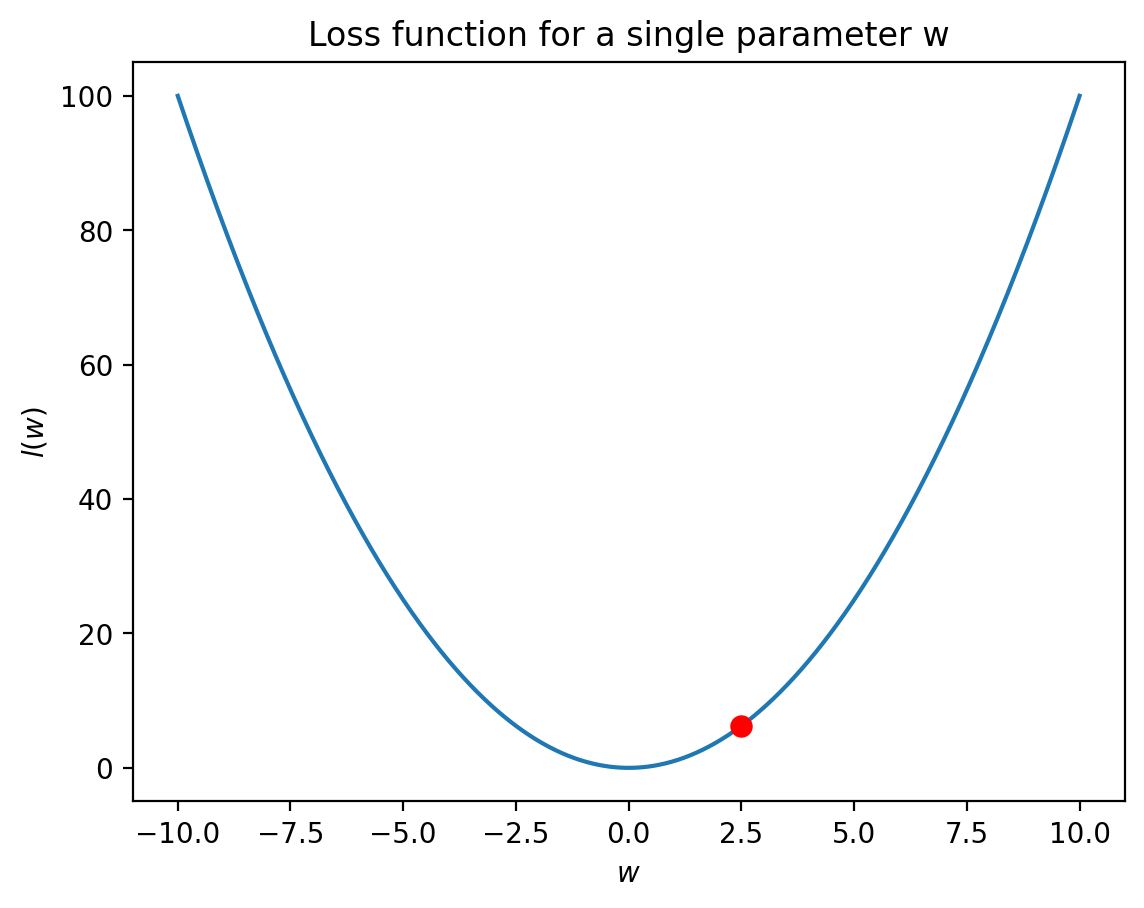

In [112]:
ws = np.linspace(-10, 10, 1000)
losses = ws ** 2

plt.plot(ws, losses)
plt.title("Loss function for a single parameter w")
plt.xlabel("$w$")
plt.ylabel("$l(w)$")

points = [(2.5, 2.5**2)]

ws, losses = list(zip(*points))
plt.scatter(ws, losses, c='r', s=50, zorder=100)

plt.show()

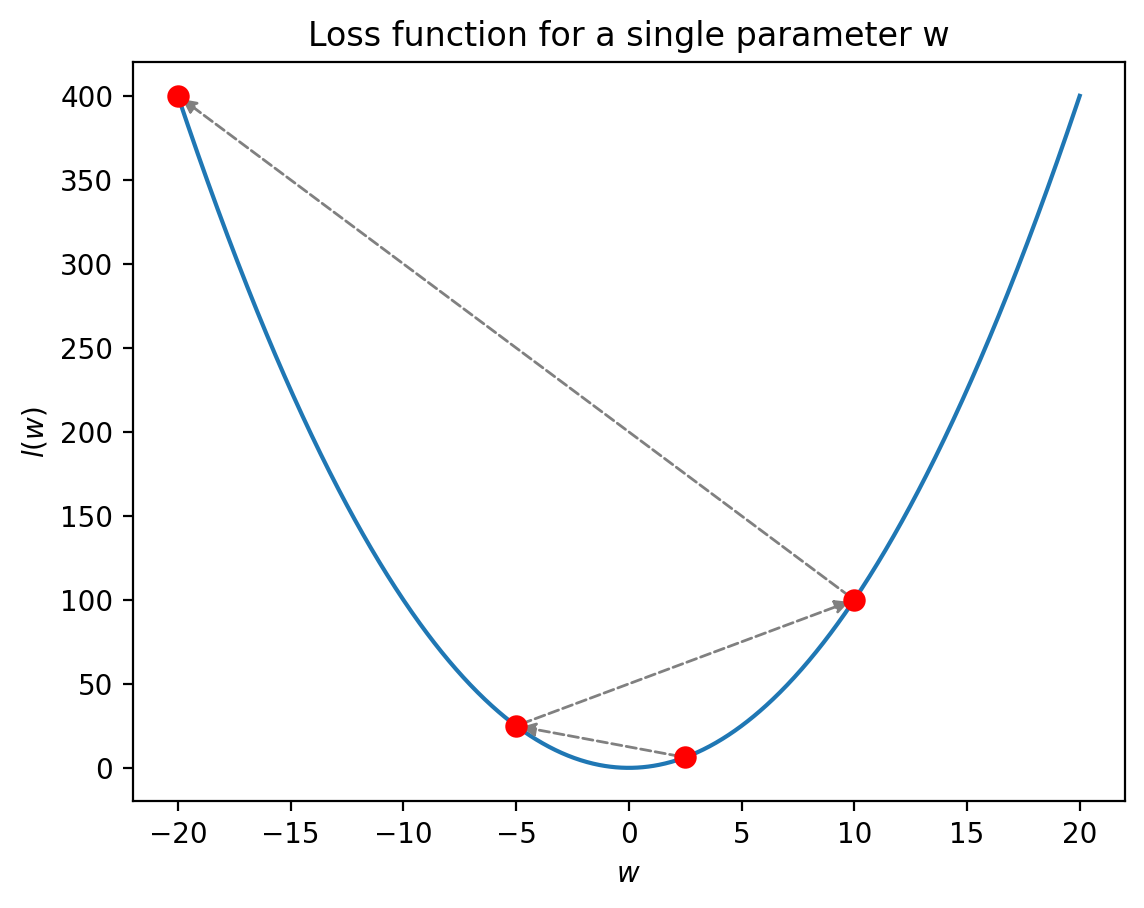

In [113]:
LEARNING_RATE = 1.5

ws = np.linspace(-20, 20, 1000)
losses = ws ** 2

fig, ax = plt.subplots()

plt.plot(ws, losses)
plt.title("Loss function for a single parameter w")
plt.xlabel("$w$")
plt.ylabel("$l(w)$")

w = 2.5
points = []
for _ in range(4):
    points.append((w, w**2))
    w = w - LEARNING_RATE * 2 * w

ws, losses = list(zip(*points))
plt.scatter(ws, losses, c='r', s=50, zorder=10)

for point, next_point in zip(points, points[1:]):
    ax.annotate("", xy=next_point, xytext=point, arrowprops=dict(arrowstyle="-|>", ls="--", color="grey"))

plt.show()

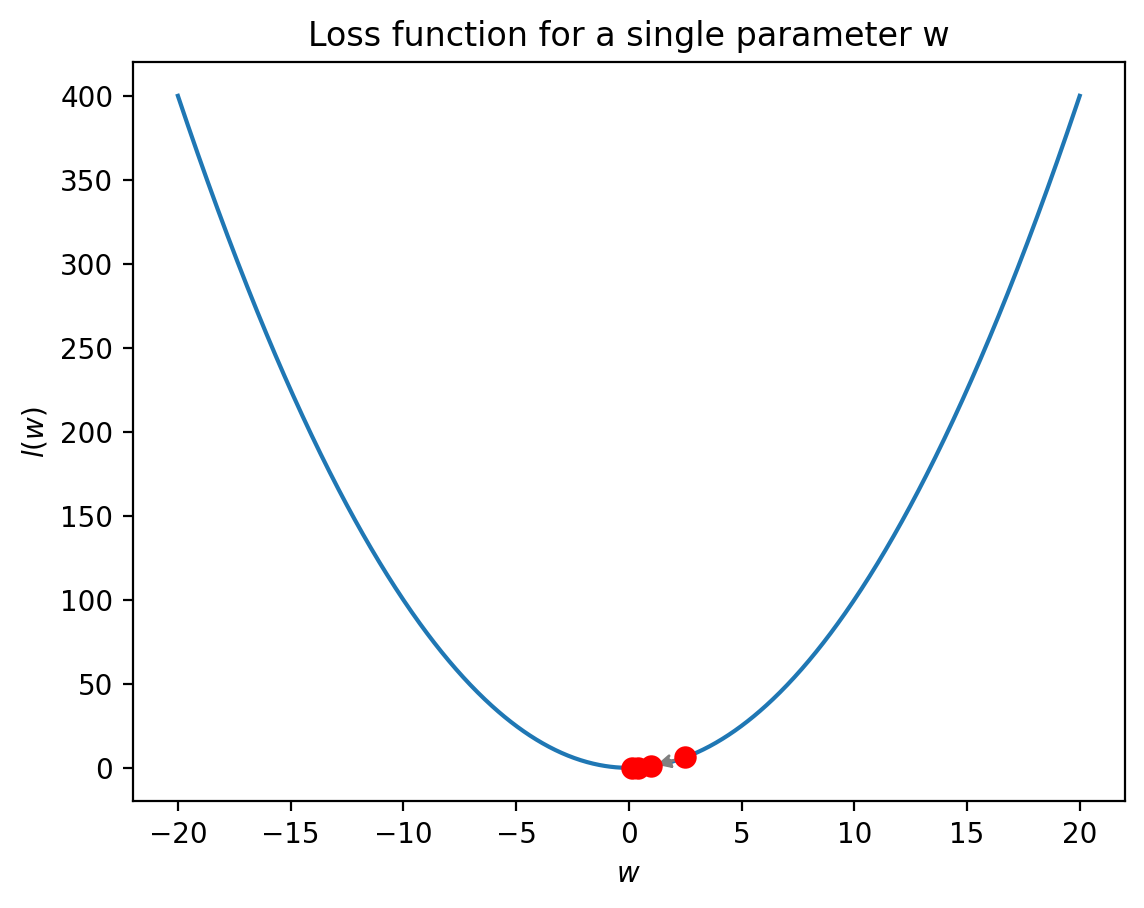

In [114]:
LEARNING_RATE = 0.3

ws = np.linspace(-20, 20, 1000)
losses = ws ** 2

fig, ax = plt.subplots()

plt.plot(ws, losses)
plt.title("Loss function for a single parameter w")
plt.xlabel("$w$")
plt.ylabel("$l(w)$")

w = 2.5
points = []
for _ in range(4):
    points.append((w, w**2))
    w = w - LEARNING_RATE * 2 * w

ws, losses = list(zip(*points))
plt.scatter(ws, losses, c='r', s=50, zorder=10)

for point, next_point in zip(points, points[1:]):
    ax.annotate("", xy=next_point, xytext=point, arrowprops=dict(arrowstyle="-|>", ls="--", color="grey"))

plt.show()